In [15]:
# 花の好み×性年齢、業態　対応分析（コレスポンデンス分析） 色調＋SD法形容詞対分解　双一極化スコア法、中立は別にフラッグ処理

"""
# 色調＋SD法形容詞対分解　双一極化スコア法、中立は別にフラッグ処理－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－

# (1) Q17系　スタイル好み
# SD法形容詞対の分解　元の「双極的7点尺度」を「2つの一方向嗜好軸」に展開する方式

# たとえば、「かわいいー渋い」のペアの場合、いったん分解して「かわいい」と「渋い」を別々のアイテムとしてスコア化
# 左の形容詞（ここでは「かわいい」）: １＝３、２＝２、３＝１点でスコア化
# 中立　４＝０　として独立項目　→「フラッグ」を立てて別変数「かわいい（左側形容詞名）（中立）」、マップでは表示せず、別表を提示　
# 右側の形容詞は、5＝１点、6＝２点、7＝３点、という割り当て
# 逆転項目も、ここではそのまま（調査票通りの左右順序＝パターン2とは違うので注意）


# (2) Q15系　色調好み
#　色調の好み　１（ネガティブ）～4（どちらでもない）～7（ポジティブ）
#  これも、Q15_xの列を、スコアに応じて、3つに分解する
#　新列名	内容	対応スコア
#  Q15_1_neg	ネガティブ側スコア	1〜3 → 3,2,1
#  Q15_1_center	中立（フラグ or 1）	4 → 1（または1点）
#  Q15_1_pos	ポジティブ側スコア	5〜7 → 1,2,3
#　表示ラベルは、辞書参照　Q15_1なら「ビビッド」（カラーパレット名）＋（）の形
#　「ビビッド（ネガティブ）」「ビビッド（中立）」「ビビッド（ポジティブ）」

"""

    

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D


# 主成分分析
from sklearn.decomposition import PCA

# コレスポンデンス分析用
import prince
from prince import CA


# 日本語フォントをインストールする
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語フォントを使用するためにimportする

#フォント名を指定
plt.rcParams['font.family'] = 'Yu Gothic'   # 游ゴシック Mediumフォント指定
plt.rcParams['font.weight'] = 'medium'

C:\Users\gv\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 1． CSVファイルの読み込みデータの読み込み

#CSVファイルのパス
file_path = "YOUR＿FILE.csv"

# CSVファイルの読み込み 日本語フォントが入っているために文字コードを指定
df = pd.read_csv(file_path, encoding="utf-8")

In [3]:
# 2  前処理　

#(1) Q17_x、Q15＿ｘの分極化、スコア配分　7点尺度、SD法データの項目処理

"""
# 考え方　拡張型SDスコア化
# SD法の1つの7点項目（例：「かわいい―渋い」）を、2つの“嗜好評価軸”に展開する：
# → 両極を別々の“好み指標”に変換

"""

# ------------------------------------------
# 【Step 1】元データからCA用のDataFrameを作成
# ------------------------------------------

# 必要な列名
q15_columns = [f"Q15_{i}" for i in range(1, 6)]  # 色調
q17_columns = [f"Q17_{i}" for i in range(1, 16)]  # スタイル
id_and_keys = ["KEY", "QSAGE", "GATE", "QBD"]

# 必要列だけを抽出
ca_raw_df = df[id_and_keys + q15_columns + q17_columns].copy()
ca_raw_df

,KEY,QSAGE,GATE,QBD,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q17_1,...,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15
0,100000419,2,1,1,4,7,7,4,7,2,...,5,2,2,7,2,7,2,2,7,2
1,100000931,1,1,1,7,7,7,7,7,3,...,6,1,6,2,4,7,7,6,7,7
2,100000991,1,1,1,6,5,4,6,5,3,...,3,2,5,3,4,4,7,6,2,5
3,100001106,4,1,1,7,7,7,7,7,6,...,1,6,1,1,6,2,2,2,1,7
4,100001211,1,1,1,3,4,6,5,6,3,...,2,3,3,2,3,6,3,3,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,100000982,7,4,9,2,6,1,2,2,2,...,4,4,3,4,3,4,5,4,4,2
514,100001192,5,4,9,3,6,1,1,4,4,...,4,5,4,3,4,4,5,4,4,3
515,100001225,8,4,9,3,4,5,3,5,2,...,6,2,6,2,2,3,6,6,2,2
516,100001613,6,4,9,3,7,6,5,7,4,...,4,3,4,4,5,3,5,5,4,6


In [4]:
# -----------------------------------------------------------------------------
# 【Step 2】Q15，Q17の各項目を、左右の形容詞に分解してスコア化
# -----------------------------------------------------------------------------

# 7点尺度の分解と、スコア割り当て（左右ともに 3点満点）

"""
# 回答値	形容詞左／色調ネガティブ側	形容詞右／色調ポジティブ側	中立
# 1	 3	 0	 0
# 2	 2	 0	 0
# 3	 1	 0	 0
# 4	 0	 0	 1
# 5	 0	 1	 0
# 6	 0	 2	 0
# 7	 0	 3	 0

# 中立フラグの「1」は、中立列のフラグ用のマーカーであって、点数ではない　
# CAには使わず、「中立率ランキング」や「中心層分析」に使う
# 可視化時に「中立クラスタ」を浮かび上がらせる
# 回答傾向の“無難派”を識別する

"""

# Q15（色調）　分解スコア化（3,2,1 方式）
for col in q15_columns:
    base = col + "_"
    
    # ネガティブ側（1～3 → 3,2,1）
    ca_raw_df[base + "neg"] = df[col].map({1: 3, 2: 2, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0})
    
    # ポジティブ側（5～7 → 1,2,3）
    ca_raw_df[base + "pos"] = df[col].map({1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3})
    
    # 中立（4 → フラグ = 1）
    ca_raw_df[base + "center"] = df[col].apply(lambda x: 1 if x == 4 else 0)



# Q17（スタイル　SD法）　ここでは逆転項目はなし　すべて分解するので、必要ない

# Q17の分解スコア化（3点満点）
for col in q17_columns:
    base = col + "_"
    
    # 左側形容詞：1～3 → 3,2,1点
    ca_raw_df[base + "left"] = df[col].map({1: 3, 2: 2, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0})
    
    # 右側形容詞：5～7 → 1,2,3点
    ca_raw_df[base + "right"] = df[col].map({1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3})
    
    # 中立フラグ：4 → 1
    ca_raw_df[base + "center"] = df[col].apply(lambda x: 1 if x == 4 else 0)

    
# -----------------------------------------------------------------------------
# 【Step 3】データフレームの確認
# -----------------------------------------------------------------------------
    
# 現在のCA用DataFrame (ca_all_input)
ca_all_input = ca_raw_df.copy()

# 重複列なしの確認
assert ca_all_input.columns.duplicated().sum() == 0, "列名が重複しています"
    
    
# カラムの確認
print("列数:", len(ca_all_input.columns))
print("カラム一覧:")
print(ca_all_input.columns.tolist())

ca_all_input

列数: 84
カラム一覧:
['KEY', 'QSAGE', 'GATE', 'QBD', 'Q15_1', 'Q15_2', 'Q15_3', 'Q15_4', 'Q15_5', 'Q17_1', 'Q17_2', 'Q17_3', 'Q17_4', 'Q17_5', 'Q17_6', 'Q17_7', 'Q17_8', 'Q17_9', 'Q17_10', 'Q17_11', 'Q17_12', 'Q17_13', 'Q17_14', 'Q17_15', 'Q15_1_neg', 'Q15_1_pos', 'Q15_1_center', 'Q15_2_neg', 'Q15_2_pos', 'Q15_2_center', 'Q15_3_neg', 'Q15_3_pos', 'Q15_3_center', 'Q15_4_neg', 'Q15_4_pos', 'Q15_4_center', 'Q15_5_neg', 'Q15_5_pos', 'Q15_5_center', 'Q17_1_left', 'Q17_1_right', 'Q17_1_center', 'Q17_2_left', 'Q17_2_right', 'Q17_2_center', 'Q17_3_left', 'Q17_3_right', 'Q17_3_center', 'Q17_4_left', 'Q17_4_right', 'Q17_4_center', 'Q17_5_left', 'Q17_5_right', 'Q17_5_center', 'Q17_6_left', 'Q17_6_right', 'Q17_6_center', 'Q17_7_left', 'Q17_7_right', 'Q17_7_center', 'Q17_8_left', 'Q17_8_right', 'Q17_8_center', 'Q17_9_left', 'Q17_9_right', 'Q17_9_center', 'Q17_10_left', 'Q17_10_right', 'Q17_10_center', 'Q17_11_left', 'Q17_11_right', 'Q17_11_center', 'Q17_12_left', 'Q17_12_right', 'Q17_12_center', 'Q17_13_l

,KEY,QSAGE,GATE,QBD,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q17_1,...,Q17_12_center,Q17_13_left,Q17_13_right,Q17_13_center,Q17_14_left,Q17_14_right,Q17_14_center,Q17_15_left,Q17_15_right,Q17_15_center
0,100000419,2,1,1,4,7,7,4,7,2,...,0,2,0,0,0,3,0,2,0,0
1,100000931,1,1,1,7,7,7,7,7,3,...,0,0,2,0,0,3,0,0,3,0
2,100000991,1,1,1,6,5,4,6,5,3,...,0,0,2,0,2,0,0,0,1,0
3,100001106,4,1,1,7,7,7,7,7,6,...,0,2,0,0,3,0,0,0,3,0
4,100001211,1,1,1,3,4,6,5,6,3,...,0,1,0,0,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,100000982,7,4,9,2,6,1,2,2,2,...,0,0,0,1,0,0,1,2,0,0
514,100001192,5,4,9,3,6,1,1,4,4,...,0,0,0,1,0,0,1,1,0,0
515,100001225,8,4,9,3,4,5,3,5,2,...,0,0,2,0,2,0,0,2,0,0
516,100001613,6,4,9,3,7,6,5,7,4,...,0,0,1,0,0,0,1,0,2,0


In [5]:
# (2) ラベル定義

# -----------------------------------------------------------------------------
# 【Step 1】ラベル辞書
# -----------------------------------------------------------------------------

# Q17の分解形容詞ラベル 極性＋中立値

adjective_labels_split = {
    "Q17_1_left": "かわいい",         "Q17_1_right": "渋い",             "Q17_1_center": "かわいい（中立）",
    "Q17_2_left": "季節",             "Q17_2_right": "定番",             "Q17_2_center": "季節（中立）",
    "Q17_3_left": "カジュアル",       "Q17_3_right": "フォーマル",       "Q17_3_center": "カジュアル（中立）",
    "Q17_4_left": "大ぶり",           "Q17_4_right": "小ぶり",           "Q17_4_center": "大ぶり（中立）",
    "Q17_5_left": "ゴージャス",        "Q17_5_right": "シック",          "Q17_5_center": "ゴージャス（中立）",
    "Q17_6_left": "野趣",             "Q17_6_right": "都会的",           "Q17_6_center": "野趣（中立）",
    "Q17_7_left": "洋風",             "Q17_7_right": "和風",             "Q17_7_center": "洋風（中立）",
    "Q17_8_left": "やさしい",         "Q17_8_right": "クール",           "Q17_8_center": "やさしい（中立）",
    "Q17_9_left": "シルキー",         "Q17_9_right": "でこぼこ",         "Q17_9_center": "シルキー（中立）",
    "Q17_10_left": "どっしり",         "Q17_10_right": "ふわふわ",         "Q17_10_center": "ふわふわ（中立）",
    "Q17_11_left": "ひらひら",         "Q17_11_right": "ぷっくり",         "Q17_11_center": "ひらひら（中立）",
    "Q17_12_left": "陰影",           "Q17_12_right": "透明感",             "Q17_12_center": "透明感（中立）",
    "Q17_13_left": "癒される",         "Q17_13_right": "気分の上がる",     "Q17_13_center": "癒される（中立）",
    "Q17_14_left": "目新しい",       "Q17_14_right": "なつかしい",         "Q17_14_center": "目新しい（中立）",
    "Q17_15_left": "艶やか",             "Q17_15_right": "清楚",           "Q17_15_center": "艶やか（中立）"
}


# Q15の色調ラベル + 分極名付き
color_labels = {
    "Q15_1": "ビビッドカラー",
    "Q15_2": "パステルカラー",
    "Q15_3": "ニュアンスカラー（くすみ）",
    "Q15_4": "ダークカラー",
    "Q15_5": "モノトーン"
}

# Q15の分解版ラベル
color_labels_split = {}
for q15_col, base_label in color_labels.items():
    color_labels_split[q15_col + "_neg"] = f"{base_label}（ネガティブ）"
    color_labels_split[q15_col + "_pos"] = f"{base_label}（ポジティブ）"
    color_labels_split[q15_col + "_center"] = f"{base_label}（中立）"



# 性年齢（QSAGQ列）
qsage_labels = {
    1: "男性20代",
    2: "男性30代",
    3: "男性40代",
    4: "男性50代",
    5: "女性20代",
    6: "女性30代",
    7: "女性40代",
    8: "女性50代"
}


# 業態ラベル（GATE）
gate_to_business = {
    1: "花店",
    2: "スーパー",
    3: "ホームセンター",
    4: "園芸店"
}

# 店舗ラベル（QBD）
qbd_to_store = {
    1: "日比谷花壇",
    2: "青フラ",
    3: "花専門店",
    4: "イオン",
    5: "その他スーパー",
    6: "カインズ",
    7: "その他HC",
    8: "オザキ",
    9: "その他園芸店"
}


In [6]:
# -----------------------------------------------------------------------------
# 【Step 2】データフレーム整備
# -----------------------------------------------------------------------------

# 分極化が終わったら、元のQ15, Q17を削除
ca_all_input.drop(columns=q15_columns + q17_columns, inplace=True)


In [7]:
# -----------------------------------------------------------------------------
# 【Step 3】全ラベル辞書の統合と内容確認
# -----------------------------------------------------------------------------

# ラベル対応確認（ラベル未定義の列をチェック）

# 全ラベル辞書の統合
all_label_dict = {}
all_label_dict.update(adjective_labels_split)  # Q17系（left/right/center）
all_label_dict.update(color_labels_split)      # Q15系（neg/pos/center）

# ca_all_input のスコア列だけを対象にチェック
score_columns = ca_all_input.columns.difference(["QSAGE", "GATE", "QBD", "KEY"], sort=False)

# 未対応の列を抽出
unlabeled_columns = [col for col in score_columns if col not in all_label_dict]

print("⚠️ ラベルが定義されていない列:")
for col in unlabeled_columns:
    print(f"  - {col}")
    
print(f"\n✅ 定義済みラベル数: {len(all_label_dict)} / カラム数: {len(score_columns)}")


# 対応リストを一覧表示
print("🔍 ラベル対応一覧（定義されているもののみ）:")
for col in score_columns:
    label = all_label_dict.get(col, "（未定義）")
    print(f"{col:20s} → {label}")

⚠️ ラベルが定義されていない列:

✅ 定義済みラベル数: 60 / カラム数: 60
🔍 ラベル対応一覧（定義されているもののみ）:
Q15_1_neg            → ビビッドカラー（ネガティブ）
Q15_1_pos            → ビビッドカラー（ポジティブ）
Q15_1_center         → ビビッドカラー（中立）
Q15_2_neg            → パステルカラー（ネガティブ）
Q15_2_pos            → パステルカラー（ポジティブ）
Q15_2_center         → パステルカラー（中立）
Q15_3_neg            → ニュアンスカラー（くすみ）（ネガティブ）
Q15_3_pos            → ニュアンスカラー（くすみ）（ポジティブ）
Q15_3_center         → ニュアンスカラー（くすみ）（中立）
Q15_4_neg            → ダークカラー（ネガティブ）
Q15_4_pos            → ダークカラー（ポジティブ）
Q15_4_center         → ダークカラー（中立）
Q15_5_neg            → モノトーン（ネガティブ）
Q15_5_pos            → モノトーン（ポジティブ）
Q15_5_center         → モノトーン（中立）
Q17_1_left           → かわいい
Q17_1_right          → 渋い
Q17_1_center         → かわいい（中立）
Q17_2_left           → 季節
Q17_2_right          → 定番
Q17_2_center         → 季節（中立）
Q17_3_left           → カジュアル
Q17_3_right          → フォーマル
Q17_3_center         → カジュアル（中立）
Q17_4_left           → 大ぶり
Q17_4_right          → 小ぶり
Q17_4_center         → 大ぶり（中立）
Q17_5_left           → 

In [9]:
# 3．平均スコア表（CA入力） クロス集計表作成　

# (1)CA入力行列の作成（汎化）

"""
# 性年齢＋店舗＋業態マトリクスを一括生成（拡張汎化対応）
# 中立列（_center）を除外　平均スコアをとってCA分析

# 汎用化＋中立除外済みのCAマトリクス作成関数

# この関数の機能（expanded_ca()）
用途：
Q15/Q17の7点SD法データを　分極スコア化（ネガ・ポジ／左右）＋中立除外
指定した複数カテゴリ（性年齢・店舗・業態…）ごとに
**クロス集計平均スコア表（CAマトリクス）**を出力

さらに 対応分析（CA）も一体で実行 → 座標・寄与率を返す

得られる出力（6変数）：
　変数	内容
　mat	クロス集計された CA入力マトリクス（行＝属性カテゴリ、列＝分極スコア）
　model	prince.CA() によるCAモデル
　row	行カテゴリ（性年齢・店舗・業態）の座標
　col	スコア項目（スタイル・色調）の座標
　inertia	各軸の寄与率（第1軸～第n軸）
　var	使用された分極スコア列リスト
 
"""

# 関数定義　expanded_ca
import prince

def expanded_ca(df, q15, q17, keys, labels, label_dict, n=5):
    """
    拡張対応CA処理（中立除外・性年齢＋店舗＋業態）
    - df: 元データ
    - q15, q17: Q15, Q17列名リスト
    - keys: ['QSAGE', 'QBD', 'GATE'] などグループキー
    - labels: {'QSAGE': ..., 'QBD': ..., 'GATE': ...}
    - label_dict: スコア列の日本語ラベル
    - n: 軸数（既定=5）
    """
    # 分極スコア化
    raw = df[["KEY"] + keys + q15 + q17].copy()

    for col in q15:
        base = col + "_"
        raw[base + "neg"] = df[col].map({1:3, 2:2, 3:1, 4:0, 5:0, 6:0, 7:0})
        raw[base + "pos"] = df[col].map({1:0, 2:0, 3:0, 4:0, 5:1, 6:2, 7:3})
        raw[base + "center"] = df[col].apply(lambda x: 1 if x==4 else 0)

    for col in q17:
        base = col + "_"
        raw[base + "left"] = df[col].map({1:3, 2:2, 3:1, 4:0, 5:0, 6:0, 7:0})
        raw[base + "right"] = df[col].map({1:0, 2:0, 3:0, 4:0, 5:1, 6:2, 7:3})
        raw[base + "center"] = df[col].apply(lambda x: 1 if x==4 else 0)

    raw.drop(columns=q15 + q17, inplace=True)

    var = [c for c in raw.columns
           if any(k in c for k in ["_neg", "_pos", "_left", "_right"])
           and not c.endswith("_center")]

    # マトリクス作成
    mats = []
    for k in keys:
        m = raw.groupby(k)[var].mean().round(2)
        m.index = m.index.map(labels[k])
        m.columns = [label_dict.get(c, c) for c in m.columns]
        mats.append(m)

    mat = pd.concat(mats, axis=0)

    # コレスポンデンス分析（CA） 実行のための関数内定義
    model = prince.CA(n_components=n, random_state=42).fit(mat)
    row = model.row_coordinates(mat)
    col = model.column_coordinates(mat)
    inertia = np.array(model.explained_inertia_)

    return mat, model, row, col, inertia, var


In [10]:
# 4. コレスポンデンス分析（CA）の実行

# (1) クロス集計生成～CA　関数実行（中立除外・汎用）

mat, model, row, col, inertia, var = expanded_ca(
    df=df,
    q15=[f"Q15_{i}" for i in range(1, 6)],
    q17=[f"Q17_{i}" for i in range(1, 16)],
    keys=["QSAGE", "QBD", "GATE"],
    labels={"QSAGE": qsage_labels, "QBD": qbd_to_store, "GATE": gate_to_business},
    label_dict=all_label_dict
)


In [12]:
# (2) CAの各軸の寄与率、累積寄与率 一覧表

# -----------------------------------------------------------------------------
# 【Step 1】各軸の寄与率、累積寄与率
# -----------------------------------------------------------------------------
    
# 寄与率、累積寄与率 出力関数
def summarize_axis_inertia(inertia, n_axis=5):
    """
    軸ごとの寄与率と累積寄与率を表形式で返す
    - inertia: explained_inertia_ のリストまたは配列
    - n_axis: 表示する軸数（初期値=5）
    """
    inertia = np.array(inertia)
    n = min(n_axis, len(inertia))
    df = pd.DataFrame({
        "軸": [f"軸{i+1}" for i in range(n)],
        "寄与率（%）": (inertia[:n] * 100).round(2),
        "累積寄与率（%）": (np.cumsum(inertia[:n]) * 100).round(2)
    })
    return df


# -----------------------------------------------------------------------------
# 【Step 2】総慣性の計算
# -----------------------------------------------------------------------------
    
# 総慣性　関数
def summarize_axis_inertia_full(model):
    inertia = np.array(model.explained_inertia_)
    df = pd.DataFrame({
        "軸": [f"軸{i+1}" for i in range(len(inertia))],
        "寄与率（%）": (inertia * 100).round(2),
        "累積寄与率（%）": (np.cumsum(inertia) * 100).round(2)
    })
    total = model.total_inertia_
    return df, total


# -----------------------------------------------------------------------------
# 【Step 3】軸の寄与率 一覧表出力
# -----------------------------------------------------------------------------
    
# 一覧表　関数実行　
# 寄与率
df_inertia = summarize_axis_inertia(inertia, n_axis=5)

# 総慣性
df_inertia, total_inertia = summarize_axis_inertia_full(model)

# 一覧表
print('寄与率、累積寄与率　性年齢＋店＋業態別')
display(df_inertia)
print(f"総慣性（Total Inertia）: {total_inertia:.6f}")



寄与率、累積寄与率　性年齢＋店＋業態別


,軸,寄与率（%）,累積寄与率（%）
0,軸1,31.23,31.23
1,軸2,17.08,48.31
2,軸3,10.56,58.86
3,軸4,9.63,68.49
4,軸5,7.60,76.09


総慣性（Total Inertia）: 0.045077


In [57]:
# (3) 修正　寄与率結果を見て、「業態」は外して再分析

# -----------------------------------------------------------------------------
# 【Step 1】修正のための関数書き換え
# -----------------------------------------------------------------------------

# 元のexpanded_caを書き換え　
mat, model, row, col, inertia, var = expanded_ca(
    df=df,
    q15=[f"Q15_{i}" for i in range(1, 6)],
    q17=[f"Q17_{i}" for i in range(1, 16)],
    keys=["QSAGE", "QBD"],  # 👈 業態（"GATE"）はここから削除！
    labels={
        "QSAGE": qsage_labels,
        "QBD": qbd_to_store
    },
    label_dict=all_label_dict,
    n=5
)

# -----------------------------------------------------------------------------
# 【Step 2】修正寄与率 一覧表出力
# -----------------------------------------------------------------------------

# 一覧表　関数実行　
# 寄与率
df_inertia = summarize_axis_inertia(inertia, n_axis=5)


# 総慣性
df_inertia, total_inertia = summarize_axis_inertia_full(model)

# 一覧表
print('寄与率、累積寄与率　性年齢・店別')
display(df_inertia)
print(f"総慣性（Total Inertia）: {total_inertia:.4f}")



寄与率、累積寄与率　性年齢・店別


,軸,寄与率（%）,累積寄与率（%）
0,軸1,30.65,30.65
1,軸2,17.99,48.64
2,軸3,10.27,58.91
3,軸4,9.29,68.20
4,軸5,7.70,75.90


総慣性（Total Inertia）: 0.0510


In [14]:
"""
# 寄与率と累積寄与率　自力計算する場合　※ここは性年齢別データ

# -----------------------------------------------------------------------------
# 【Step 1】寄与率　ca の eig- を使って計算する場合
# -----------------------------------------------------------------------------

# CA 実行後に eig_ を使って寄与率を取得 
# eig_df = ca.eig_.copy()
# eig_ →　この属性がないというエラーになるため、自力計算


# -----------------------------------------------------------------------------
# 【Step 2】寄与率　自力計算する場合
# -----------------------------------------------------------------------------

# 自力で計算
from sklearn.decomposition import TruncatedSVD
import numpy as np

# CAの入力行列（ca_matrix）を行列形式に変換
X = ca_matrix.values

# 行・列の合計 → 確率行列に変換
grand_total = X.sum()
P = X / grand_total

# 行・列の合計（周辺分布）
row_sums = P.sum(axis=1).reshape(-1, 1)
col_sums = P.sum(axis=0).reshape(1, -1)

# 期待値とのズレをスケーリング
expected = row_sums @ col_sums
S = (P - expected) / np.sqrt(expected)

# 特異値分解（SVD）
svd = TruncatedSVD(n_components=5, random_state=42)
svd.fit(S)

# 寄与率・累積寄与率計算
explained = svd.explained_variance_ratio_
cumulative = np.cumsum(explained)

# 表にまとめる
explained_df = pd.DataFrame({
    "軸": [f"軸{i+1}" for i in range(len(explained))],
    "寄与率（%）": (explained * 100).round(2),
    "累積寄与率（%）": (cumulative * 100).round(2)
})

print("▶ 手動計算による寄与率（CA1〜） 性年齢別:")
display(explained_df)


# -----------------------------------------------------------------------------
# 【Step 3】総慣性の計算
# -----------------------------------------------------------------------------

# 総慣性（Total Inertia） Inertia 列の合計
total_inertia = ca.total_inertia_
print(f"▶ CAの総慣性（Total Inertia） 性年齢別: {total_inertia:.6f}")

# 総慣性（total inertia）は クロス集計全体のばらつき（＝構造の強さ）」を示す  全軸の Inertia（分散成分）を合計したもの

"""

'\n# 寄与率と累積寄与率\u3000自力計算する場合\u3000※ここは性年齢別データ\n\n# -----------------------------------------------------------------------------\n# 【Step 1】寄与率\u3000ca の eig- を使って計算する場合\n# -----------------------------------------------------------------------------\n\n# CA 実行後に eig_ を使って寄与率を取得 \n# eig_df = ca.eig_.copy()\n# eig_ →\u3000この属性がないというエラーになるため、自力計算\n\n\n# -----------------------------------------------------------------------------\n# 【Step 2】寄与率\u3000自力計算する場合\n# -----------------------------------------------------------------------------\n\n# 自力で計算\nfrom sklearn.decomposition import TruncatedSVD\nimport numpy as np\n\n# CAの入力行列（ca_matrix）を行列形式に変換\nX = ca_matrix.values\n\n# 行・列の合計 → 確率行列に変換\ngrand_total = X.sum()\nP = X / grand_total\n\n# 行・列の合計（周辺分布）\nrow_sums = P.sum(axis=1).reshape(-1, 1)\ncol_sums = P.sum(axis=0).reshape(1, -1)\n\n# 期待値とのズレをスケーリング\nexpected = row_sums @ col_sums\nS = (P - expected) / np.sqrt(expected)\n\n# 特異値分解（SVD）\nsvd = TruncatedSVD(n_components=5, random_state=42

In [11]:
"""
# 寄与率、総慣性　概念整理と計算方法　ーーーーーーーーーーーーー

# 総慣性とは（total inertia）
# 「行と列の独立性のなさ（偏りの大きさ）」を表す　
# CAにおける「分散の総量」にあたるもの（PCAにおける全分散と同じような位置づけ）
#　Total Inertia　=𝜒2／𝑁　　つまり、クロス表における χ²値を全体のデータ数で割ったもの

# 総慣性の判断基準

# 総慣性の値 	状態・ 解釈
# 0.00〜0.01	 構造がほとんどない（行と列がほぼ独立）
# 0.01〜0.03	 軽度の構造あり（分析する価値あり）
# 0.03〜0.05	 構造が比較的はっきり出ている
# 0.05以上	強い構造（カテゴリ間に明確な違いあり）
# ※ 実データでは「0.01〜0.03」に分布することが多い 特に属性別の平均スコアをCAにかけたときには控えめな値が自然

#　今回の 0.018762 はどうか？
#「やや小さめ」だが、平均スコアで集計している（QSAGE別）＆中立も多い構造なら納得
# CAでは 0.01〜0.05 程度でも構造が見えることがある　重要なのは「主軸の寄与率が高く、構造が明瞭に出ているか」


# 寄与率は “各軸の慣性 ÷ 総慣性 × 100

# 総慣性の出し方　ca.total_inertia_ vs　svd.explained_variance_.sum() 
# ca.total_inertia_ が正しい その理由
# prince.CA クラスでは、CAの理論に基づいた以下の手順を踏んでいる
#　クロス集計表の相対度数行列 𝑃
#　行・列の周辺分布 → 独立モデルの期待値 　𝐸
#　標準化残差行列 　(𝑃−𝐸)/𝐸 root
#  行重み・列重みを使ってχ²距離ベースの空間構成
#  固有値の合計（inertia）＝ 総慣性（＝ χ²統計量 / N）
# これにより得られる ca.total_inertia_ は、統計的に理論に基づいた正しい総慣性値  正規の統計的検定に使える 全体ばらつき

# svd.explained_variance_.sum() はなにを出しているのか？
# total_inertia = svd.explained_variance_.sum()
# SVD対象の行列（標準化残差 S）**の主成分の分散合計 方向としては一致しているが、スケールが異なる
# スケール変更後のローカル空間で見たばらつき
# svd.fit(S) の S 行列（標準化残差行列）が：*CAの核部分（中心化された情報）を保持しているが、CAの枠組みに必要な「重み・正規化」などを完全に再現していない


# 計算方法	値	解釈	信頼性
# ca.total_inertia_	0.01876	正規のCA定義に基づいた値	✅ 信頼してOK　報告に使える
#　svd.explained_variance_.sum()	0.00219	SVD空間での相対的なばらつき	△ 補助的



# 概念の整理　慣性、固有値　ーーーーーーーーーーーーーーーーーーーーーーーーーー
# prince 0.7.1 ：寄与率の正しい取得方法　 ca.eig_ から取得
# explained_inertia_ の代わりに eig_ から完全に取得可能
# 寄与率・累積寄与率・総慣性
# prince の CA モデルにおける eig_ は、「固有値（eigenvalues）とそれに基づく各種統計量」を含むデータフレーム

# 列名	意味
# Eigenvalue	各軸の固有値（＝その軸の情報量）
# Inertia	固有値と同じ意味で使われる（情報のばらつき）
# Percentage of explained inertia	各軸が全体の中でどれだけの割合を占めるか（寄与率）
# Cumulative percentage of explained inertia	上位からの累積寄与率

# 参考：CAとPCAの違い
# 用語	PCA（主成分分析）	CA（コレスポンデンス分析）
# 固有値	分散	            慣性（Inertia）
# 寄与率	分散比	           慣性比（Inertia Ratio）
# 行列	共分散行列	      相対度数行列から変換

# CA1/CA2の寄与率を自力で SVD から計算
# CA の本質は、「相対度数行列の対数スケーリングと SVD（特異値分解）」
#　Pandas + NumPy + sklearn.decomposition.TruncatedSVD を使って自前で CA に相当する処理

#  この手法は CAの数学的本質そのもの
# P: 相対度数行列
# expected: 独立仮説の期待値
# (P - expected) / √expected: 標準化残差行列
# SVD: 寄与率・座標の抽出

# CAとχ二乗検定　CAは、視覚化に特化した「χ²検定の多次元版」とも言える
# χ²が「全体に差があるか」を見るのに対し、 → CAは「どのカテゴリが、どれと似ていて、どれと違うのか」を図で見せてくれる
# だからこそ、CAの中心成分は「χ²距離」に基づいている
# 行や列の相対的な距離は、実際に χ²距離（カイ二乗距離）で測られる　つまり、CA空間で遠い = 統計的に大きく異なる

# ✅ CAとχ²検定のつながり（ざっくり）
# ステップ	        χ²検定	               コレスポンデンス分析（CA）
# 1. クロス集計表	観測度数と期待度数を比較	同じく、観測度数 vs 期待度数を使う
# 2. 期待度数の計算	
# 3. 残差の計算　　(Oij​−E ij​) 2/Eij　　　　分母はEijの平方根（標準化残差）
# 4. 指標の統合	χ²統計量を合計する	       標準化残差行列を SVD にかけて「主成分」的な構造を抽出
# 5. 分析結果の利用	p値で有意差の有無を検定	空間的な位置・距離として可視化（マップにする）
# まとめ　クロス表 → 期待値・残差 → 標準化残差 → SVD（特異値分解）→ マップ

"""


In [58]:
# 5. CAプロット　マッピング

# (1) マッピングの準備：軸パターン（1×2、1×3、2×3）を自動描画する汎用関数

# 描画関数の定義
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_ca_axes_styled(row_coords, col_coords, original_columns, explained, axis_pairs):
    for x_axis, y_axis in axis_pairs:
        fig, ax = plt.subplots(figsize=(11, 9), dpi=150)
        texts = []

        # 背景色
        ax.set_facecolor((0.988, 0.984, 0.965, 0.6))

        # 行カテゴリ（性年齢＋店舗）
        for i, label in enumerate(row_coords.index):
            x = row_coords.iloc[i, x_axis]
            y = row_coords.iloc[i, y_axis]
            if "男性" in label or "女性" in label:
                plt.scatter(x, y, color='#405584', label="性年齢" if i == 0 else "", zorder=3)
                texts.append(plt.text(x, y, label, color='#405584', fontsize=11, weight='bold'))
            else:
                plt.scatter(x, y, color='#007E7A', marker='o', s=80,
                            edgecolor='white', linewidth=1.5,
                            label="店舗" if i == 0 else "", zorder=4)
                texts.append(plt.text(x, y, label, color='#007E7A', fontsize=11, weight='bold'))

        # 列カテゴリ（スタイル・色調）
        label_q15_drawn = False
        label_q17_drawn = False
        for i in range(len(col_coords)):
            colname = original_columns[i]
            display_label = col_coords.index[i]
            if colname.startswith("Q15_"):
                c = '#4B5931'; m = '^'; label_color = c
                label_name = "色調" if not label_q15_drawn else None
                label_q15_drawn = True
            elif colname.startswith("Q17_"):
                c = '#990000'; m = 'D'; label_color = c
                label_name = "スタイル" if not label_q17_drawn else None
                label_q17_drawn = True
            else:
                c = 'gray'; m = 'x'; label_color = c; label_name = None

            ax.scatter(col_coords.iloc[i, x_axis], col_coords.iloc[i, y_axis],
                       color=c, marker=m, edgecolors='white', linewidths=0.5,
                       alpha=0.9, label=label_name, zorder=2)
            texts.append(
                ax.text(col_coords.iloc[i, x_axis], col_coords.iloc[i, y_axis],
                        display_label, color=label_color, fontsize=12)
            )

        # ラベル重なり調整
        adjust_text(texts, only_move={'points': 'y', 'text': 'xy'},
                    arrowprops=dict(arrowstyle="-", color='#322C10', lw=0.5))

        # 寄与率
        x_pct = explained[x_axis] * 100
        y_pct = explained[y_axis] * 100
        total_pct = x_pct + y_pct

        plt.axhline(0, color='gray', linestyle='dotted')
        plt.axvline(0, color='gray', linestyle='dotted')
        plt.xlabel(f"軸{x_axis + 1}（{x_pct:.1f}％）", fontsize=12)
        plt.ylabel(f"軸{y_axis + 1}（{y_pct:.1f}％）", fontsize=12)

        plt.text(0.98, 0.02,
                 f"軸{x_axis + 1}＋軸{y_axis + 1}の寄与率：{total_pct:.1f}％",
                 transform=plt.gca().transAxes,
                 fontsize=12, color='#322C10', ha='right', va='bottom')

        plt.title(f"コレスポンデンス分析マップ：スタイル・色調 × 性年齢・店舗 軸{x_axis+1}×軸{y_axis+1}", pad=20)
        plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.1))
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.tight_layout()
        plt.show()


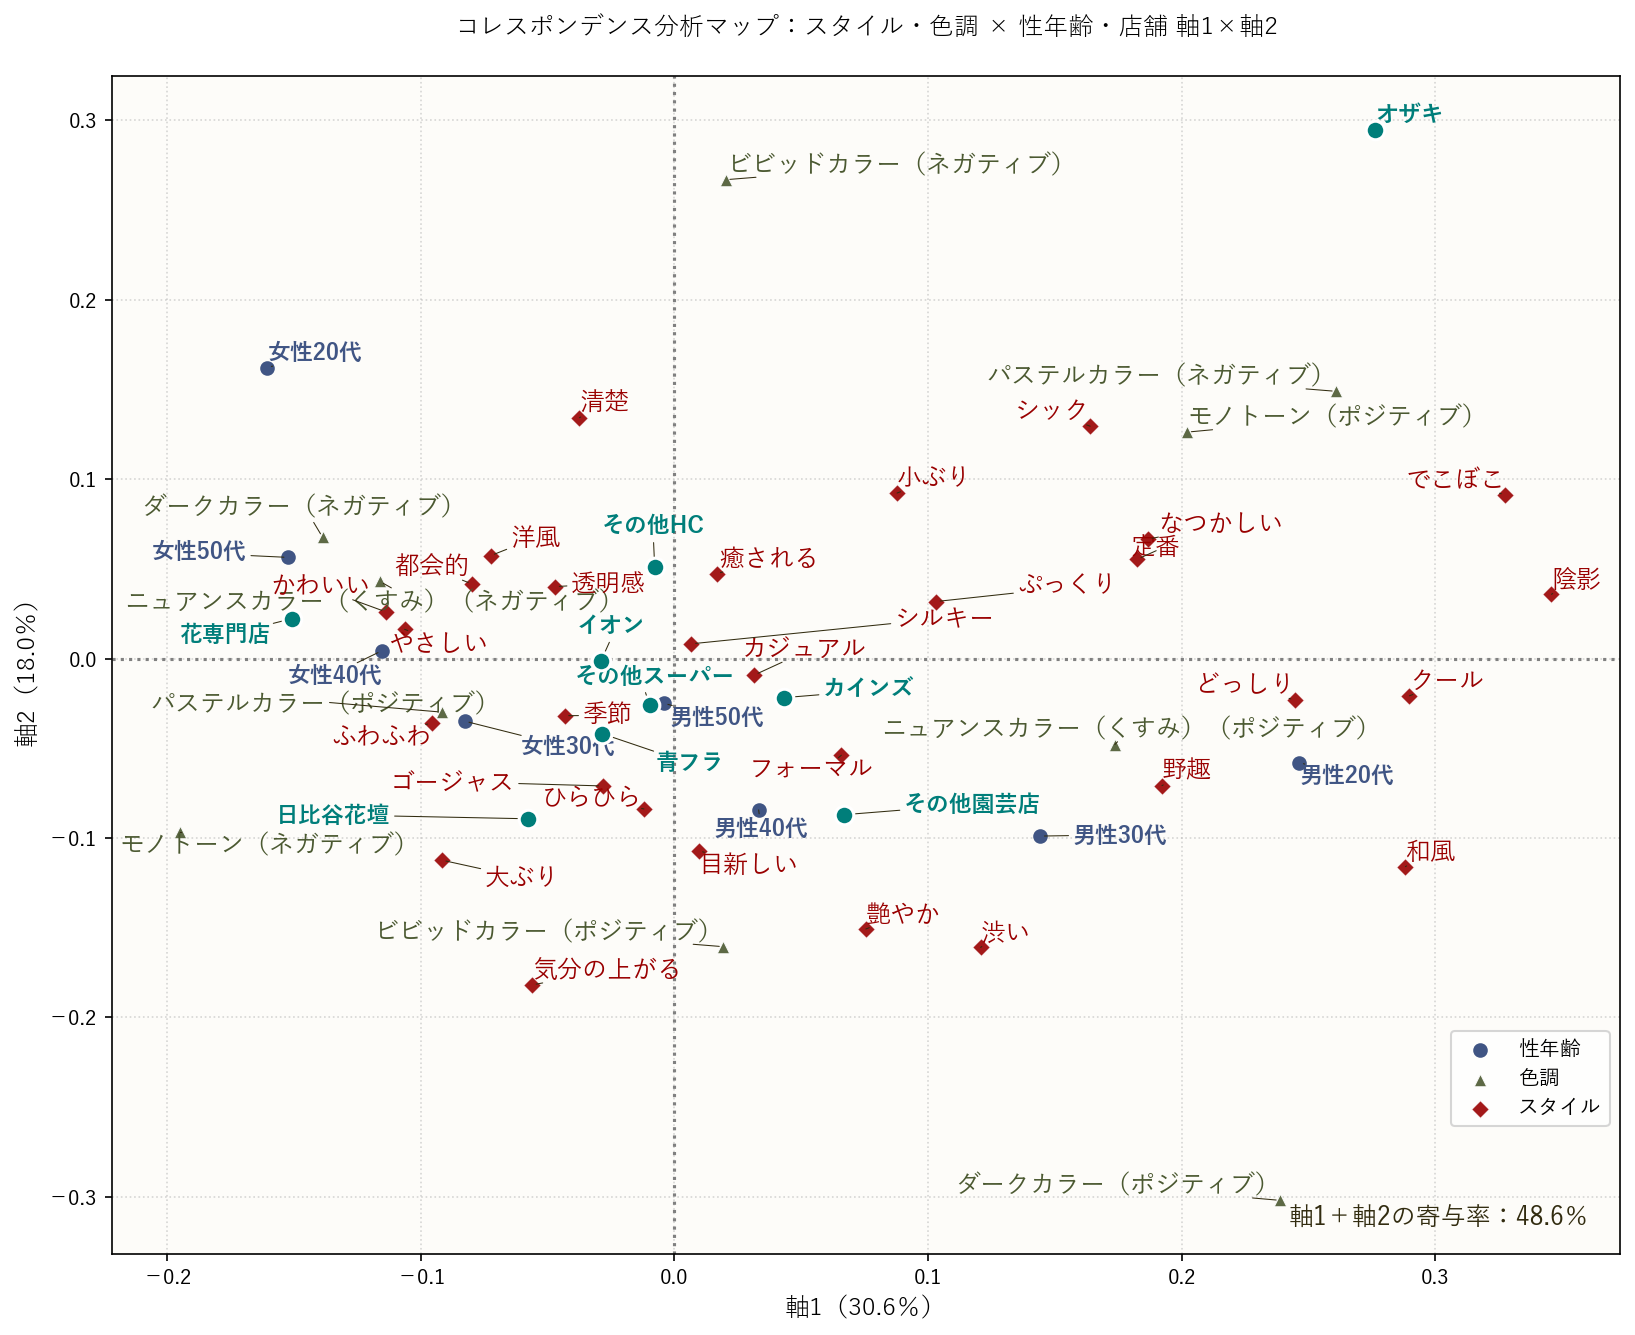

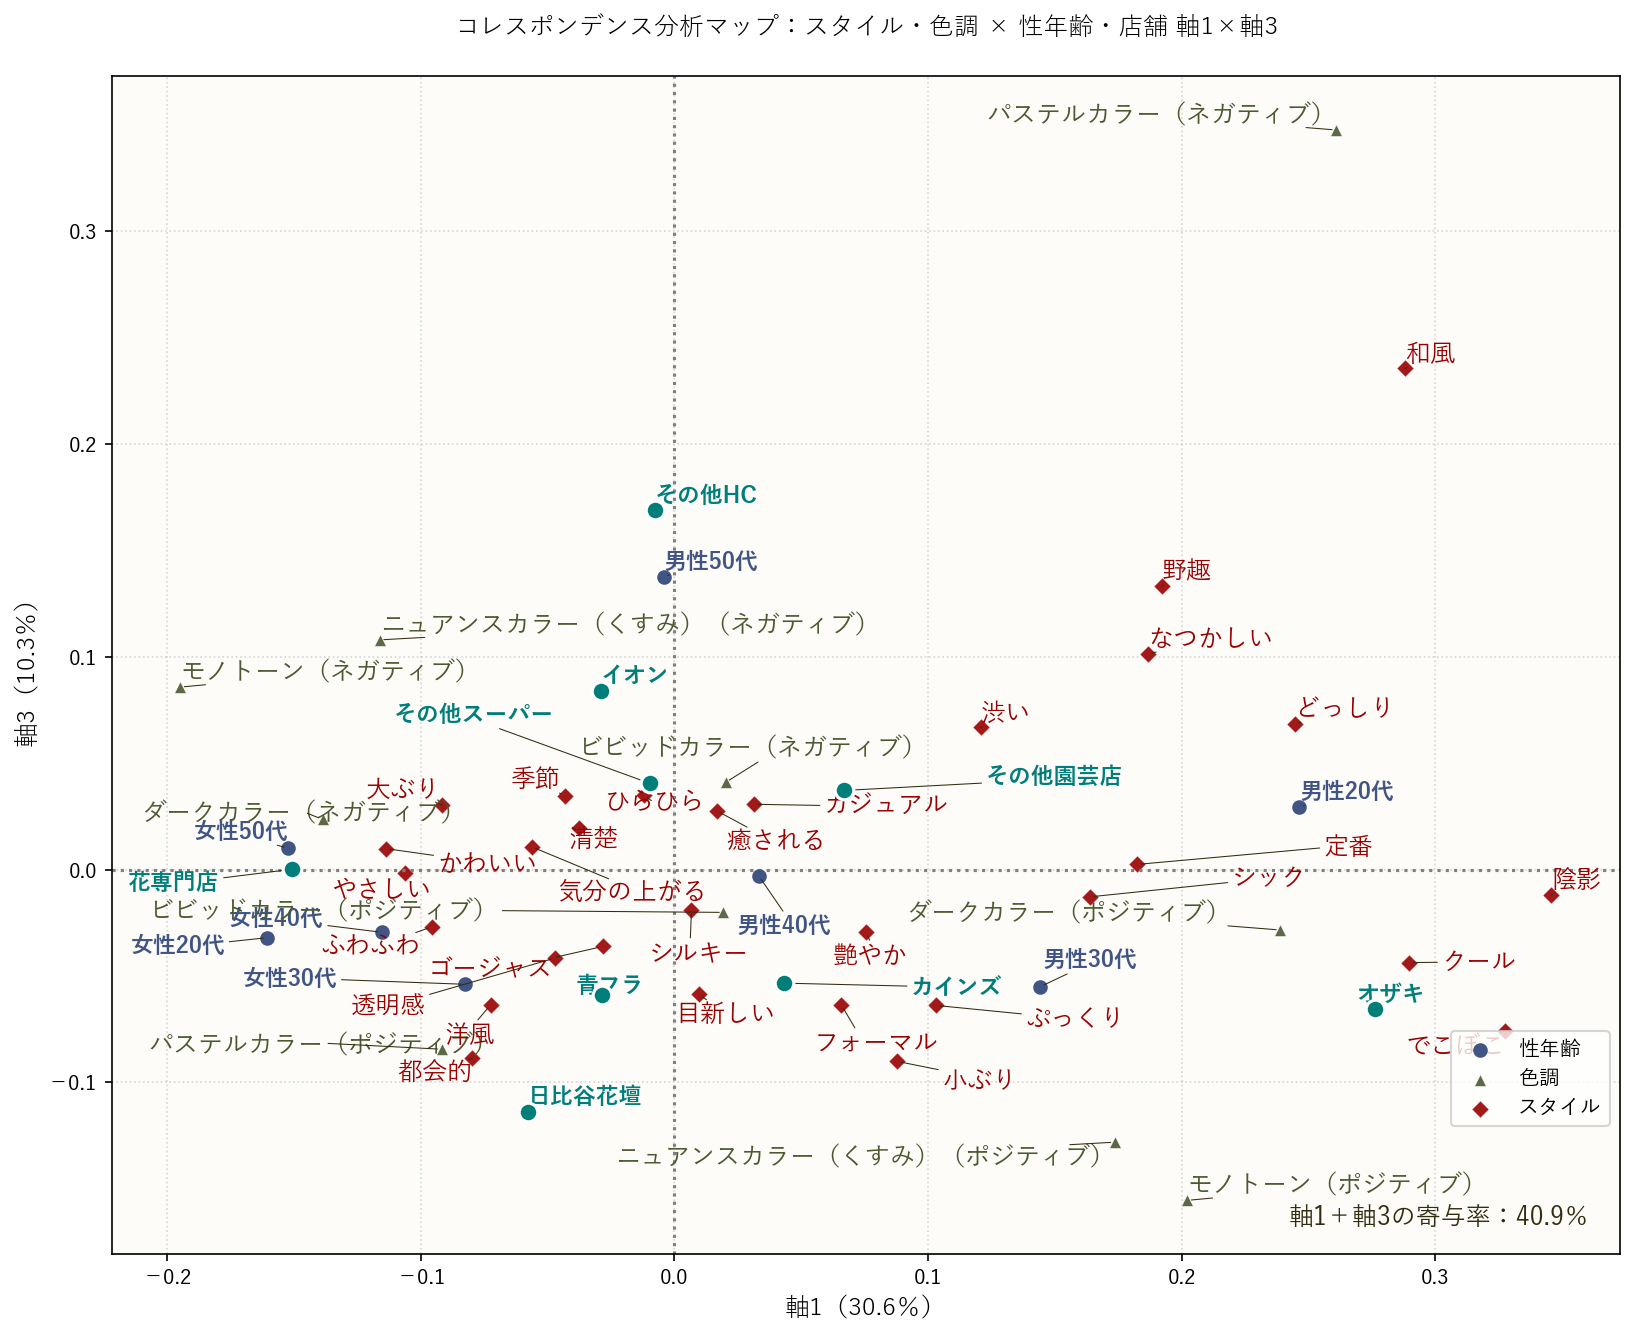

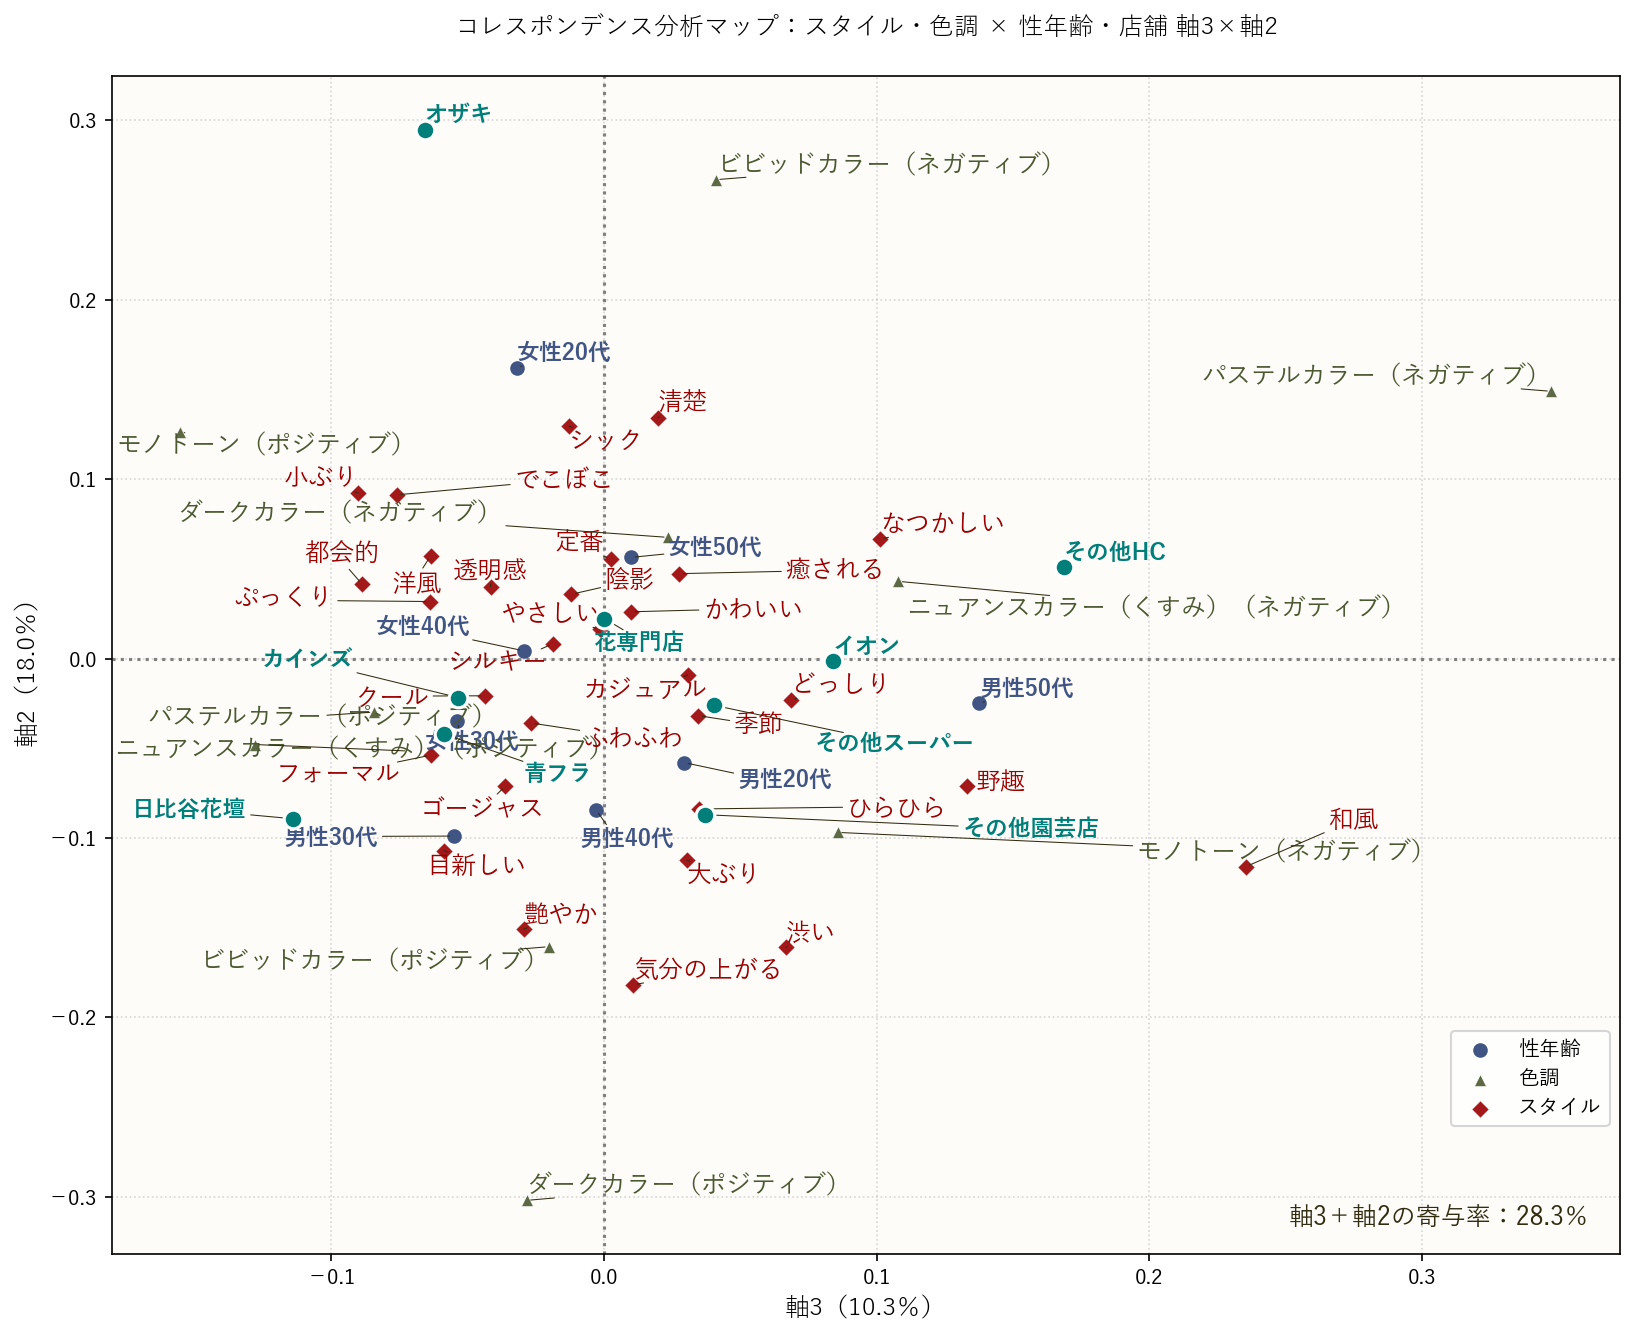

In [59]:

#(2) 描画　関数実行
# 描画
plot_ca_axes_styled(
    row_coords=row,
    col_coords=col,
    original_columns=var,
    explained=inertia,
    axis_pairs=[(0, 1), (0, 2), (2, 1)]
)


In [60]:
# 6. 軸とマップの解釈

# (1)　軸A×軸Bの寄与度（＝列カテゴリが軸にどれだけ貢献しているか）
# 軸ごとの変数寄与度（貢献度）上位TOP表示
# 軸ごとに、正・負方向に強く寄与する変数　寄与度

# -----------------------------------------------------------------------------
# 【Step 1】SVD 特異値分解（mat から構造成分を抽出）
# -----------------------------------------------------------------------------

from sklearn.decomposition import TruncatedSVD
import numpy as np

X = mat.T.values
P = X / X.sum()
row_sums = P.sum(axis=1).reshape(-1, 1)
col_sums = P.sum(axis=0).reshape(1, -1)
expected = row_sums @ col_sums
S = (P - expected) / np.sqrt(expected)

svd = TruncatedSVD(n_components=5, random_state=42)
svd.fit(S)


"""
# このコードの手順
# SVD準備
# 行=スコア項目、列=カテゴリ 
# 相対度数に変換（確率化）
# 期待値の行列
# 標準化残差行列 S = (P - expected) / np.sqrt(expected)

# TruncatedSVD を使って S を分解

これにより、軸ごとの構造ベクトル（components_）と**分散（explained_variance_）**が得られる
# 列カテゴリの寄与度（contribution）を SVDから計算
# 寄与度 = 各変数（列）の第n軸における成分の二乗 ÷ 軸の固有値（分散）
# 第n軸の成分（loadings）と分散（= explained_variance）から寄与度を出す
"""


# -----------------------------------------------------------------------------
# 【Step 2】関数定義（軸の寄与度・成分・正負を出力）
# -----------------------------------------------------------------------------

def summarize_axis_contributions(ca_matrix, svd, axis_idx, top_n=10):
    axis_name = f"軸{axis_idx+1}"
    var_names = ca_matrix.columns
    axis_values = svd.components_[axis_idx][:len(var_names)]  # 長さを合わせる
    variance = svd.explained_variance_[axis_idx]

    contrib = (axis_values ** 2) / variance
    df = pd.DataFrame({
        f"{axis_name} 成分": axis_values,
        f"{axis_name} 寄与度": contrib
    }, index=var_names[:len(axis_values)]).round(3)

    top_pos = df.sort_values(by=f"{axis_name} 成分", ascending=False).head(top_n)
    top_neg = df.sort_values(by=f"{axis_name} 成分").head(top_n)

    summary = pd.concat([
        top_pos[[f"{axis_name} 成分"]],
        top_neg[[f"{axis_name} 成分"]].rename(columns={f"{axis_name} 成分": f"{axis_name} 成分（負）"})
    ], axis=1)

    return df.sort_values(by=f"{axis_name} 寄与度", ascending=False), summary



# -----------------------------------------------------------------------------
# 【Step 3】軸1〜3の解釈　貢献度出力（寄与度＋正負方向寄与変数）
# -----------------------------------------------------------------------------

for i in range(3):  # 軸1〜3
    contrib_df, summary_df = summarize_axis_contributions(mat, svd, axis_idx=i, top_n=10)

    print(f"\n▶ 軸{i+1} の貢献度ランキング（性年齢＋店舗）:")
    display(contrib_df.head(10))

    print(f"\n▶ 軸{i+1} の正・負方向に強く寄与する変数:")
    display(summary_df)



▶ 軸1 の貢献度ランキング（性年齢＋店舗）:


,軸1 成分,軸1 寄与度
フォーマル,0.507,687.483
ビビッドカラー（ネガティブ）,0.504,679.089
ニュアンスカラー（くすみ）（ネガティブ）,-0.335,300.947
ビビッドカラー（ポジティブ）,0.297,235.500
かわいい,-0.289,223.912
ダークカラー（ポジティブ）,-0.284,215.904
ダークカラー（ネガティブ）,-0.222,132.333
ニュアンスカラー（くすみ）（ポジティブ）,-0.167,74.367
大ぶり,0.126,42.436
モノトーン（ネガティブ）,-0.117,36.680



▶ 軸1 の正・負方向に強く寄与する変数:


,軸1 成分,軸1 成分（負）
フォーマル,0.507,NaN
ビビッドカラー（ネガティブ）,0.504,NaN
ビビッドカラー（ポジティブ）,0.297,NaN
大ぶり,0.126,NaN
定番,0.083,NaN
パステルカラー（ネガティブ）,0.061,NaN
パステルカラー（ポジティブ）,-0.008,NaN
カジュアル,-0.015,-0.015
季節,-0.019,-0.019
渋い,-0.054,-0.054



▶ 軸2 の貢献度ランキング（性年齢＋店舗）:


,軸2 成分,軸2 寄与度
フォーマル,0.705,2173.202
ニュアンスカラー（くすみ）（ネガティブ）,0.442,854.316
ビビッドカラー（ポジティブ）,-0.266,307.920
モノトーン（ネガティブ）,-0.236,243.908
大ぶり,-0.214,200.546
パステルカラー（ネガティブ）,-0.202,178.537
ビビッドカラー（ネガティブ）,-0.155,104.478
ダークカラー（ポジティブ）,0.137,82.262
カジュアル,0.130,74.214
モノトーン（ポジティブ）,-0.108,51.011



▶ 軸2 の正・負方向に強く寄与する変数:


,軸2 成分,軸2 成分（負）
フォーマル,0.705,NaN
ニュアンスカラー（くすみ）（ネガティブ）,0.442,NaN
ダークカラー（ポジティブ）,0.137,NaN
カジュアル,0.130,NaN
かわいい,0.056,NaN
ダークカラー（ネガティブ）,0.011,NaN
渋い,-0.003,NaN
定番,-0.055,-0.055
パステルカラー（ポジティブ）,-0.059,-0.059
季節,-0.065,-0.065



▶ 軸3 の貢献度ランキング（性年齢＋店舗）:


,軸3 成分,軸3 寄与度
カジュアル,0.572,2505.519
パステルカラー（ポジティブ）,0.428,1401.483
モノトーン（ネガティブ）,-0.399,1218.362
渋い,0.271,560.117
フォーマル,-0.208,331.853
モノトーン（ポジティブ）,-0.201,308.434
ビビッドカラー（ポジティブ）,-0.196,292.643
ニュアンスカラー（くすみ）（ポジティブ）,-0.188,270.323
定番,-0.177,240.647
季節,0.134,137.791



▶ 軸3 の正・負方向に強く寄与する変数:


,軸3 成分,軸3 成分（負）
カジュアル,0.572,NaN
パステルカラー（ポジティブ）,0.428,NaN
渋い,0.271,NaN
季節,0.134,NaN
大ぶり,0.121,NaN
ビビッドカラー（ネガティブ）,0.104,NaN
ダークカラー（ポジティブ）,0.032,NaN
かわいい,0.001,0.001
パステルカラー（ネガティブ）,-0.009,-0.009
ダークカラー（ネガティブ）,-0.098,-0.098


In [74]:

"""
# 軸とマップの解釈

# 「軸1×軸3の寄与度（＝列カテゴリが軸にどれだけ貢献しているか）」

# 列カテゴリの寄与度（contribution）を SVDから計算
# 寄与度 = 各変数（列）の第n軸における成分の二乗 ÷ 軸の固有値（分散）
# 第n軸の成分（loadings）と分散（= explained_variance）から寄与度を出す
axis1_contrib = (svd.components_[0] ** 2) / svd.explained_variance_[0]
axis3_contrib = (svd.components_[2] ** 2) / svd.explained_variance_[2]

# 結果を表にまとめる（列カテゴリ名は ca_matrix.columns から）
contrib_df = pd.DataFrame({
    "変数名": ca_matrix.columns,
    "寄与度（軸1）": axis1_contrib,
    "寄与度（軸3）": axis3_contrib
}).set_index("変数名")

# 寄与度（軸3）で並べ替え
contrib_df = contrib_df.round(4).sort_values(by="寄与度（軸3）", ascending=False)

print("▶ 軸1×軸3の寄与度（列カテゴリ） 性年齢別　上位10件:")
display(contrib_df.head(10).round(2))

# 寄与度（contribution）は 比率ベースではなく、軸ごとの「相対的な影響力」
# prince が出す寄与度は、理論的には100×(成分² / 軸の固有値) とされることが多い
#　絶対値で100を超えてもOK（合計100になるとは限らない）
#　大きいほど、その変数がその軸の「主成分」として影響

"""

'\n# 軸とマップの解釈\n\n# (1)「軸1×軸3の寄与度（＝列カテゴリが軸にどれだけ貢献しているか）」をチェック\n\n# 列カテゴリの寄与度（contribution）を SVDから計算\n# 寄与度 = 各変数（列）の第n軸における成分の二乗 ÷ 軸の固有値（分散）\n# 第n軸の成分（loadings）と分散（= explained_variance）から寄与度を出す\naxis1_contrib = (svd.components_[0] ** 2) / svd.explained_variance_[0]\naxis3_contrib = (svd.components_[2] ** 2) / svd.explained_variance_[2]\n\n# 結果を表にまとめる（列カテゴリ名は ca_matrix.columns から）\ncontrib_df = pd.DataFrame({\n    "変数名": ca_matrix.columns,\n    "寄与度（軸1）": axis1_contrib,\n    "寄与度（軸3）": axis3_contrib\n}).set_index("変数名")\n\n# 寄与度（軸3）で並べ替え\ncontrib_df = contrib_df.round(4).sort_values(by="寄与度（軸3）", ascending=False)\n\nprint("▶ 軸1×軸3の寄与度（列カテゴリ） 性年齢別\u3000上位10件:")\ndisplay(contrib_df.head(10).round(2))\n\n# 寄与度（contribution）は 比率ベースではなく、軸ごとの「相対的な影響力」\n# prince が出す寄与度は、理論的には100×(成分² / 軸の固有値) とされることが多い\n#\u3000絶対値で100を超えてもOK（合計100になるとは限らない）\n#\u3000大きいほど、その変数がその軸の「主成分」として影響\n\n'

In [62]:
# (2) 各項目の重心（原点）からの距離　5軸5次元
# どのカテゴリが中心（重心）からどれだけ離れているか → 「構造的に目立っている属性」を発見するのに有効

# -----------------------------------------------------------------------------
# 【Step 1】原点からの距離を計算する関数を定義
# -----------------------------------------------------------------------------

# 定義 原点からの距離を計算する関数
# 性年齢別、店別　

def calculate_distances_from_origin(row_coords, n_axes=5):
    """
    CAの行カテゴリごとに、原点（0,0,…）からのユークリッド距離を計算する
    - row_coords: CAの行カテゴリ座標（model.row_coordinates() の出力）
    - n_axes: 何軸分の距離を計算するか（初期値＝5軸）
    - もし X が行カテゴリ（または列カテゴリ）の各軸の座標だとすると：（x1の二乗+ x2の二乗 +...+ ｘ5の二乗）の合計の平方根
    
    Returns:
    - DataFrame：各軸の座標と、原点からの距離（列名：軸1, 軸2,…, 距離）
    """
    coords = row_coords.iloc[:, :n_axes]              # 必要な軸のみ抽出（行方向＝性年齢、店別）
    squared = coords ** 2                             # 各軸を2乗
    distances = np.sqrt(squared.sum(axis=1))          # ユークリッド距離
    df = coords.copy()
    df.columns = [f"軸{i+1}" for i in range(n_axes)]   # 軸名リネーム
    df["距離"] = distances.round(3)                   # 距離列を追加
    return df.round(3)


# -----------------------------------------------------------------------------
# 【Step 2】距離計算出力（性年齢別、店別）
# -----------------------------------------------------------------------------

# 関数実行
print('CA分析 5軸（5次元）空間での原点からの距離（ユークリッド距離）性年齢別、店別')
df_distance = calculate_distances_from_origin(row, n_axes=5)
display(df_distance)



CA分析 5軸（5次元）空間での原点からの距離（ユークリッド距離）性年齢別、店別


,軸1,軸2,軸3,軸4,軸5,距離
男性20代,0.246,-0.058,0.029,-0.064,-0.099,0.281
男性30代,0.144,-0.099,-0.055,0.008,-0.071,0.197
男性40代,0.033,-0.084,-0.003,-0.021,0.104,0.139
男性50代,-0.004,-0.025,0.138,0.015,-0.007,0.141
女性20代,-0.161,0.162,-0.032,-0.101,-0.052,0.257
女性30代,-0.083,-0.035,-0.054,-0.062,0.116,0.168
女性40代,-0.115,0.004,-0.029,0.032,0.050,0.133
女性50代,-0.152,0.056,0.010,0.147,-0.062,0.228
日比谷花壇,-0.058,-0.089,-0.114,-0.077,-0.026,0.176
青フラ,-0.028,-0.042,-0.059,0.042,-0.021,0.091


In [21]:
# 列方向（好み）の距離
"""
df_col_distance = calculate_distances_from_origin(col_coords, n_axes=5)

print('CA分析 5軸（5次元）空間での原点からの距離（ユークリッド距離）カラートーン、スタイル項目別')
display(rank_by_distance(df_col_distance, top_n=10))
"""

"\ndf_col_distance = calculate_distances_from_origin(col_coords, n_axes=5)\n\nprint('CA分析 5軸（5次元）空間での原点からの距離（ユークリッド距離）カラートーン、スタイル項目別')\ndisplay(rank_by_distance(df_col_distance, top_n=10))\n"

In [63]:

# -----------------------------------------------------------------------------
# 【Step 3】各店 ー 各色調・スタイル項目 の構造的距離の可視化（手動）
# -----------------------------------------------------------------------------

# 店舗ごとに項目（色調・スタイル）との構造的距離を可視化
# ランキング形式で出力する関数 定義  rank_item_distances_by_store()


def rank_item_distances_by_store(row_coords, col_coords, top_n=10, axes=5):
    """
    店舗ごとに、距離の大きいスコア項目（色・スタイル）をランキング形式で抽出する関数
    
    Parameters:
    - row_coords: CAモデルの行カテゴリ座標（性年齢＋店舗含む DataFrame）
    - col_coords: CAモデルの列カテゴリ座標（スコア項目）
    - top_n: ランキング上位いくつを表示するか（デフォルト=10）
    - axes: 使用する軸数（通常5軸）

    Returns:
    - dict: 各店舗名をキーに、その店舗と項目との距離ランキング（DataFrame）を返す
    """

    # 性年齢以外のカテゴリ（＝店舗）だけを抽出
    stores = [label for label in row_coords.index
              if label not in ["男性20代", "男性30代", "男性40代", "男性50代",
                               "女性20代", "女性30代", "女性40代", "女性50代"]]

    results = {}

    for store in stores:
        store_vec = row_coords.loc[store].iloc[:axes].values
        distances = col_coords.iloc[:, :axes].apply(
            lambda x: np.sqrt(np.sum((x.values - store_vec) ** 2)), axis=1)
        
        ranked = distances.sort_values(ascending=False).head(top_n)
        results[store] = ranked.to_frame(name="距離")

    return results


# 表示（手動）
store_distance_ranks = rank_item_distances_by_store(row, col, top_n=10, axes=5)

# 日比谷花壇のランキング：
print('項目別　原点からの距離　日比谷花壇')
display(store_distance_ranks["日比谷花壇"])

# 他の店舗（例：青フラ、イオン、オザキ）も同様に確認可能



項目別　原点からの距離　日比谷花壇


,距離
パステルカラー（ネガティブ）,0.637460
和風,0.493314
でこぼこ,0.452970
陰影,0.451127
クール,0.428596
どっしり,0.425090
ビビッドカラー（ネガティブ）,0.421773
ダークカラー（ポジティブ）,0.380289
野趣,0.375257
なつかしい,0.364130


In [64]:
# (3) 店 × スコア項目の関係  解析自動化

# -----------------------------------------------------------------------------
# 【Step 1】店 × スコア項目の距離一覧　一括処理
# -----------------------------------------------------------------------------

# 店 × スコア項目の距離一覧を作成する関数 create_store_item_distance_matrix() 
# 各店舗ごとに「距離が近い項目」と「距離が遠い項目」を対比形式で一覧表示

# 定義　距離マトリクスを作る関数作成

def create_store_item_distance_matrix(row_coords, col_coords, axes=5):
    """
    店舗を行、スタイル・色調項目を列とした構造的距離マトリクスを作成する関数
　　各店舗の「最も遠い項目」「最も近い項目」、特定項目で“距離差”が大きい店舗はどこか？
    マップが読みづらいときの代替定量分析にもなる
    
    Parameters:
    - row_coords: model.row_coordinates()（性年齢・店舗含む DataFrame）
    - col_coords: model.column_coordinates()（スコア項目）
    - axes: 使用する軸数（通常5軸）

    Returns:
    - DataFrame：index = 店舗名、columns = スコア項目名、value = 原点からの距離（5次元空間）
    """

    # 対象店舗の抽出（性年齢を除く）
    stores = [label for label in row_coords.index
              if label not in ["男性20代", "男性30代", "男性40代", "男性50代",
                               "女性20代", "女性30代", "女性40代", "女性50代"]]

    matrix = {}

    for store in stores:
        store_vec = row_coords.loc[store].iloc[:axes].values
        distances = col_coords.iloc[:, :axes].apply(
            lambda x: np.sqrt(np.sum((x.values - store_vec) ** 2)), axis=1)
        matrix[store] = distances

    return pd.DataFrame(matrix).T.round(4)


# 距離マトリクス作成　関数適用
df_store_item_distance = create_store_item_distance_matrix(row, col, axes=5)



# -----------------------------------------------------------------------------
# 【Step 2】店別　遠近距離　
# -----------------------------------------------------------------------------

# 各店舗ごとに近い／遠い項目を抽出（上位7件ずつ）
# 関数定義
def get_top_near_far_items_by_store(distance_df, top_n=7):
    """
    距離マトリクスから、店舗ごとに「近い項目（親和性）」と「遠い項目（構造的特徴）」を抽出

    Parameters:
    - distance_df: create_store_item_distance_matrix() の出力（店舗×項目の距離 DataFrame）
    - top_n: 各方向で何件出すか（既定＝7）

    Returns:
    - dict: {店舗名: DataFrame（近い項目・遠い項目の対比表）}
    """
    results = {}

    for store in distance_df.index:
        row = distance_df.loc[store]
        closest = row.sort_values().head(top_n).to_frame(name="距離（近い順）")
        farthest = row.sort_values(ascending=False).head(top_n).to_frame(name="距離（遠い順）")
        combined = pd.concat([closest, farthest], axis=1)
        results[store] = combined

    return results

# 抽出実行
store_near_far = get_top_near_far_items_by_store(df_store_item_distance, top_n=7)

# ➃ 個別に表示
display(store_near_far["日比谷花壇"])
display(store_near_far["イオン"])
display(store_near_far["オザキ"])



,距離（近い順）,距離（遠い順）
ゴージャス,0.1070,NaN
ふわふわ,0.1169,NaN
目新しい,0.1226,NaN
パステルカラー（ポジティブ）,0.1278,NaN
シルキー,0.1587,NaN
透明感,0.1610,NaN
やさしい,0.1664,NaN
パステルカラー（ネガティブ）,NaN,0.6375
和風,NaN,0.4933
でこぼこ,NaN,0.4530


,距離（近い順）,距離（遠い順）
季節,0.0859,NaN
ニュアンスカラー（くすみ）（ネガティブ）,0.1139,NaN
ダークカラー（ネガティブ）,0.1496,NaN
シルキー,0.1545,NaN
透明感,0.1631,NaN
やさしい,0.1721,NaN
洋風,0.1740,NaN
ダークカラー（ポジティブ）,NaN,0.4261
パステルカラー（ネガティブ）,NaN,0.4260
でこぼこ,NaN,0.4186


,距離（近い順）,距離（遠い順）
シック,0.2077,NaN
でこぼこ,0.2175,NaN
モノトーン（ポジティブ）,0.2345,NaN
陰影,0.2760,NaN
定番,0.2871,NaN
小ぶり,0.2899,NaN
ビビッドカラー（ネガティブ）,0.2939,NaN
モノトーン（ネガティブ）,NaN,0.6370
ダークカラー（ポジティブ）,NaN,0.6055
気分の上がる,NaN,0.5940


In [65]:

# -----------------------------------------------------------------------------
# 【Step 3】店別　距離遠近リスト　自動化
# -----------------------------------------------------------------------------

#　店舗ごとに「距離が近い項目」と「遠い項目」を一覧表にまとめる

# 【関数定義】compile_near_far_items_table()

def compile_near_far_items_table(near_far_dict):
    """
    店舗ごとの「距離が近い項目／遠い項目」を1つの大きなDataFrameにまとめる関数

    Parameters:
    - near_far_dict: get_top_near_far_items_by_store() の出力（dict）

    Returns:
    - DataFrame：全店舗の距離項目比較表（3桁小数付き）
    """

    rows = []

    for store, df in near_far_dict.items():
        for i in range(len(df)):
            near_item = df.index[i] if pd.notna(df.index[i]) else ""
            near_val = df.iloc[i, 0]
            far_item = df.index[i] if pd.notna(df.index[i]) else ""
            far_val = df.iloc[i, 1]

            rows.append({
                "店舗": store,
                "順位": i + 1,
                "近い項目": near_item,
                "距離（近）": round(near_val, 3),
                "遠い項目": far_item,
                "距離（遠）": round(far_val, 3)
            })

    return pd.DataFrame(rows)

df_store_item_near_far = compile_near_far_items_table(store_near_far)
display(df_store_item_near_far)


,店舗,順位,近い項目,距離（近）,遠い項目,距離（遠）
0,日比谷花壇,1,ゴージャス,0.107,ゴージャス,NaN
1,日比谷花壇,2,ふわふわ,0.117,ふわふわ,NaN
2,日比谷花壇,3,目新しい,0.123,目新しい,NaN
3,日比谷花壇,4,パステルカラー（ポジティブ）,0.128,パステルカラー（ポジティブ）,NaN
4,日比谷花壇,5,シルキー,0.159,シルキー,NaN
5,日比谷花壇,6,透明感,0.161,透明感,NaN
6,日比谷花壇,7,やさしい,0.166,やさしい,NaN
7,日比谷花壇,8,パステルカラー（ネガティブ）,NaN,パステルカラー（ネガティブ）,0.638
8,日比谷花壇,9,和風,NaN,和風,0.493
9,日比谷花壇,10,でこぼこ,NaN,でこぼこ,0.453


In [66]:

# -----------------------------------------------------------------------------
# 【Step 4】全データ確認（1回だけ実行後、設定は元に戻すこと）
# -----------------------------------------------------------------------------

# 1回だけ実行 全行・全列を表示する設定

import pandas as pd

# 全行・全列表示を有効化
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(df_store_item_near_far)


# 終わったら、設定を元に戻すこと！（全部表を出力すると長く重くなるため）
# 表全体を表示
display(df_store_item_near_far)

# pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


,店舗,順位,近い項目,距離（近）,遠い項目,距離（遠）
0,日比谷花壇,1,ゴージャス,0.107,ゴージャス,NaN
1,日比谷花壇,2,ふわふわ,0.117,ふわふわ,NaN
2,日比谷花壇,3,目新しい,0.123,目新しい,NaN
3,日比谷花壇,4,パステルカラー（ポジティブ）,0.128,パステルカラー（ポジティブ）,NaN
4,日比谷花壇,5,シルキー,0.159,シルキー,NaN
5,日比谷花壇,6,透明感,0.161,透明感,NaN
6,日比谷花壇,7,やさしい,0.166,やさしい,NaN
7,日比谷花壇,8,パステルカラー（ネガティブ）,NaN,パステルカラー（ネガティブ）,0.638
8,日比谷花壇,9,和風,NaN,和風,0.493
9,日比谷花壇,10,でこぼこ,NaN,でこぼこ,0.453


,店舗,順位,近い項目,距離（近）,遠い項目,距離（遠）
0,日比谷花壇,1,ゴージャス,0.107,ゴージャス,NaN
1,日比谷花壇,2,ふわふわ,0.117,ふわふわ,NaN
2,日比谷花壇,3,目新しい,0.123,目新しい,NaN
3,日比谷花壇,4,パステルカラー（ポジティブ）,0.128,パステルカラー（ポジティブ）,NaN
4,日比谷花壇,5,シルキー,0.159,シルキー,NaN
5,日比谷花壇,6,透明感,0.161,透明感,NaN
6,日比谷花壇,7,やさしい,0.166,やさしい,NaN
7,日比谷花壇,8,パステルカラー（ネガティブ）,NaN,パステルカラー（ネガティブ）,0.638
8,日比谷花壇,9,和風,NaN,和風,0.493
9,日比谷花壇,10,でこぼこ,NaN,でこぼこ,0.453


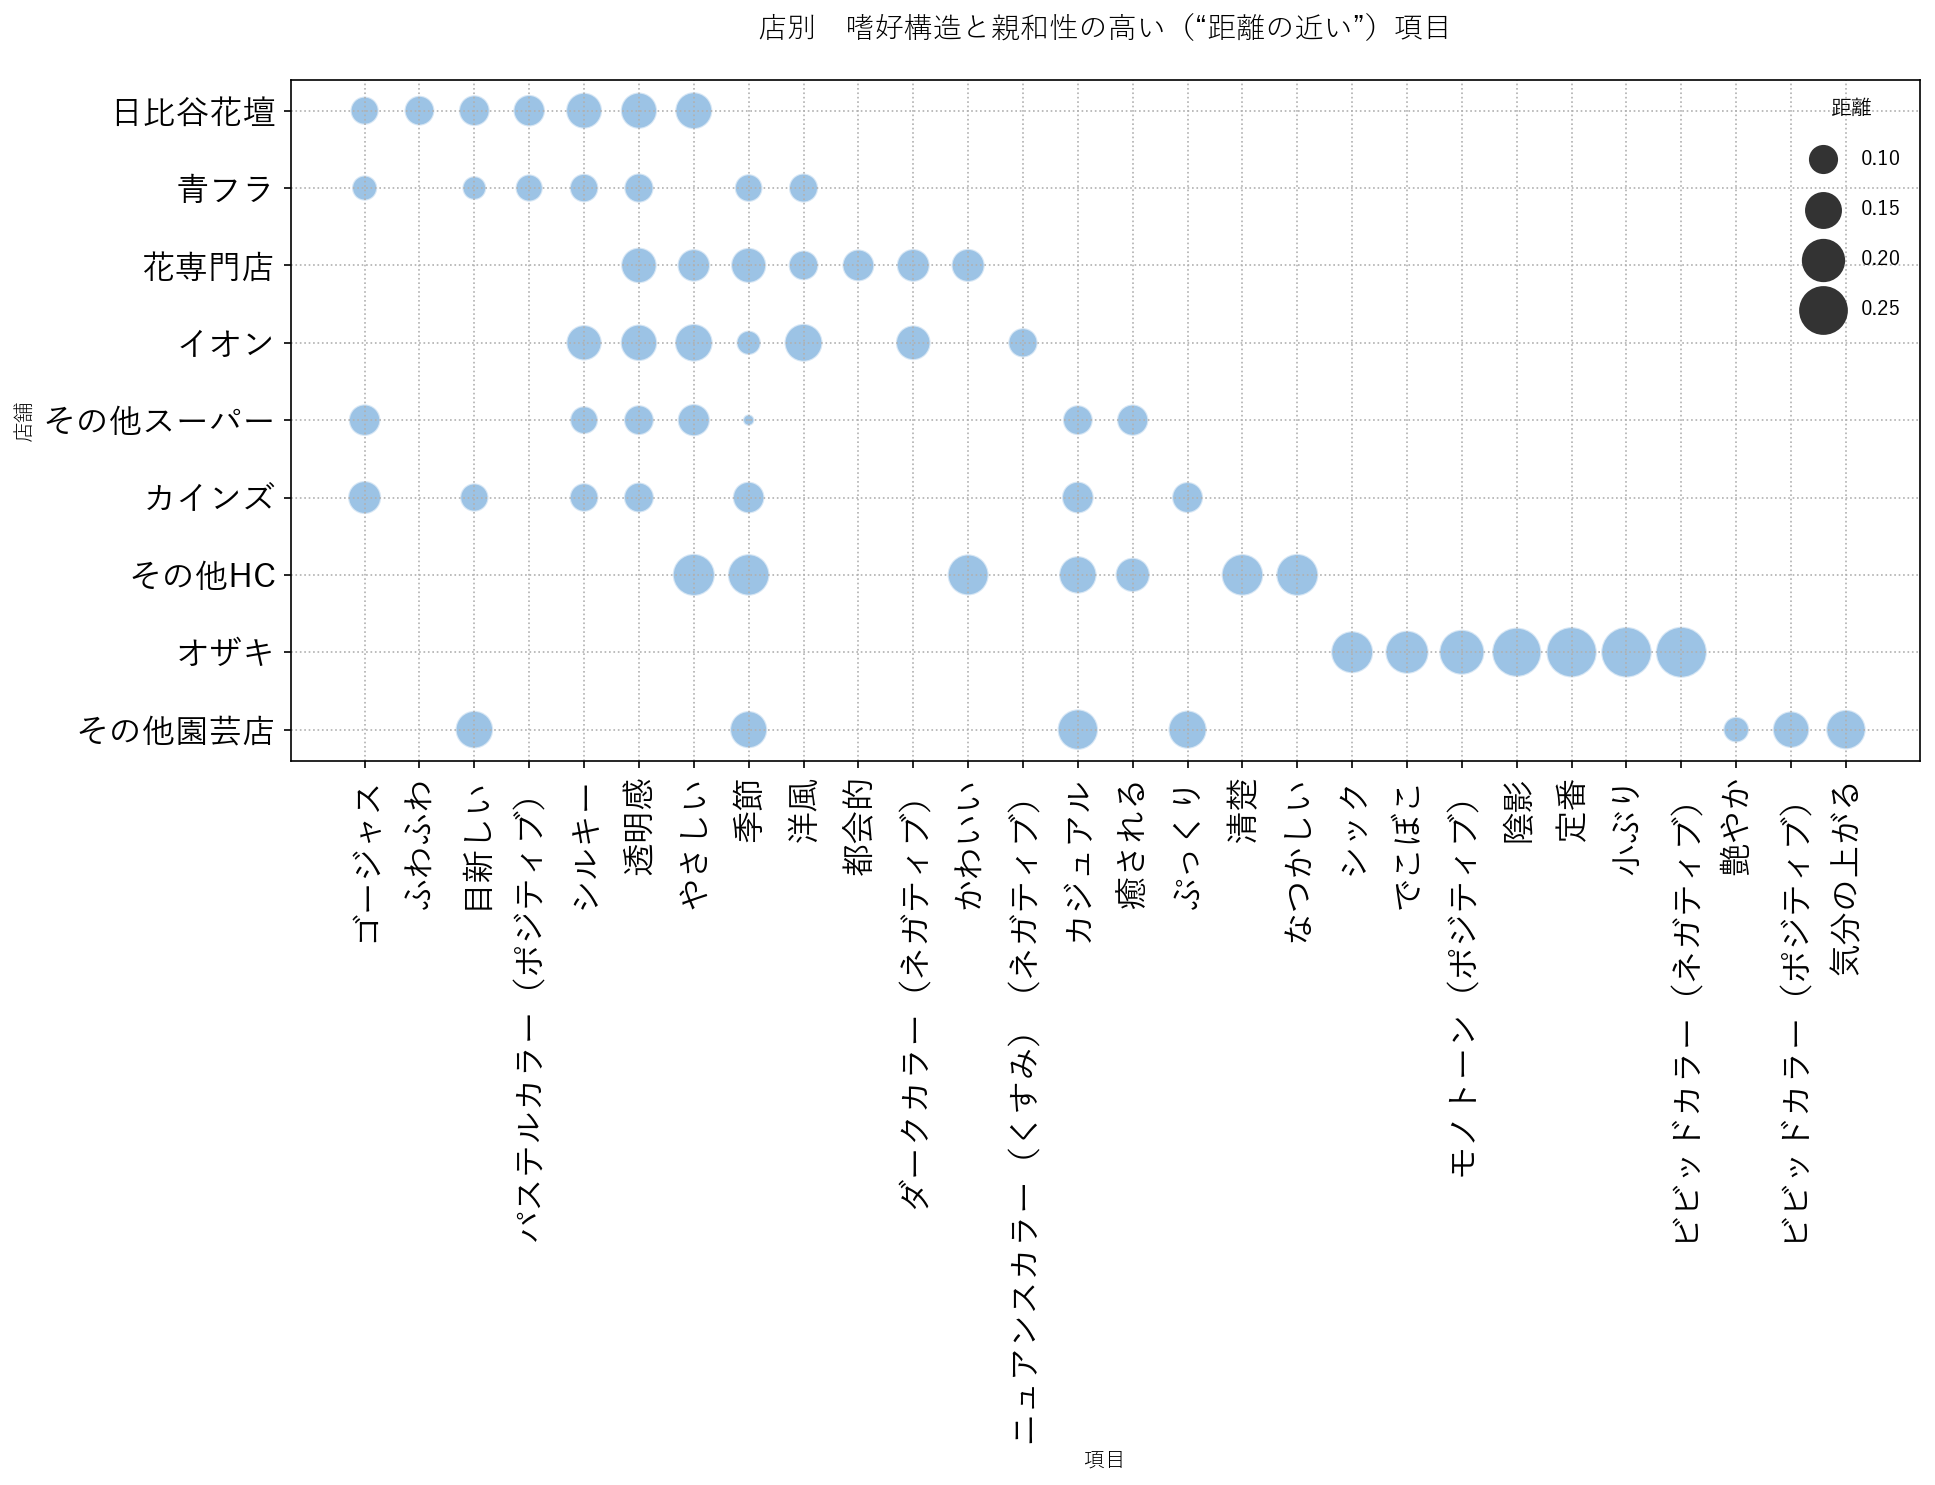

In [67]:
# (4) 可視化　店舗 × スコア項目の距離　バブルチャート

# -----------------------------------------------------------------------------
# 【Step 1】snsによる描画　店舗 × スコア項目の距離　バブルチャート
# -----------------------------------------------------------------------------

# 店舗 × スコア項目の距離
# バブルチャート

# sns で描画する場合　

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# df_store_item_near_far

def plot_bubble_distance_chart(distance_df, top_n=7):
    """
    店舗 × スコア項目の距離を、バブルの大きさで表すプロット

    Parameters:
    - distance_df: 店舗 × 項目 の距離マトリクス（DataFrame）
    - top_n: 各店舗の「距離が近い項目」をいくつ表示するか（既定=7）

    プロット仕様：
    - 横軸：項目（色調・スタイルなど）
    - 縦軸：店舗
    - バブルサイズ：距離（近いほど小さい）
    """

    records = []

    for store in distance_df.index:
        sorted_items = distance_df.loc[store].sort_values().head(top_n)
        for item, dist in sorted_items.items():
            records.append({
                "店舗": store,
                "項目": item,
                "距離": dist
            })

    df_plot = pd.DataFrame(records)

    plt.figure(figsize=(13, 10), dpi=150)
    
    #  '距離' を size と hue 両方に指定、バブルと凡例の色統一
    # color で全体を青に統一（凡例はサイズのみ）
    ax = sns.scatterplot(
        data=df_plot, x="項目", y="店舗", size="距離",
        sizes=(30, 600), legend="brief", alpha=0.6,
        color="#5B9BD5"  # 全体青
    )

    # 凡例整理
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles[1:], labels=labels[1:], title="距離",
        loc='upper right', labelspacing=1.5, frameon=False
    )

    plt.title("店別　嗜好構造と親和性の高い（“距離の近い”）項目", fontsize=14, pad=20)
    plt.xticks(rotation=90, fontsize=16) # x軸横書きの場合

    plt.yticks(fontsize=16)
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()
    

# 描画
plot_bubble_distance_chart(df_store_item_distance, top_n=7)
 


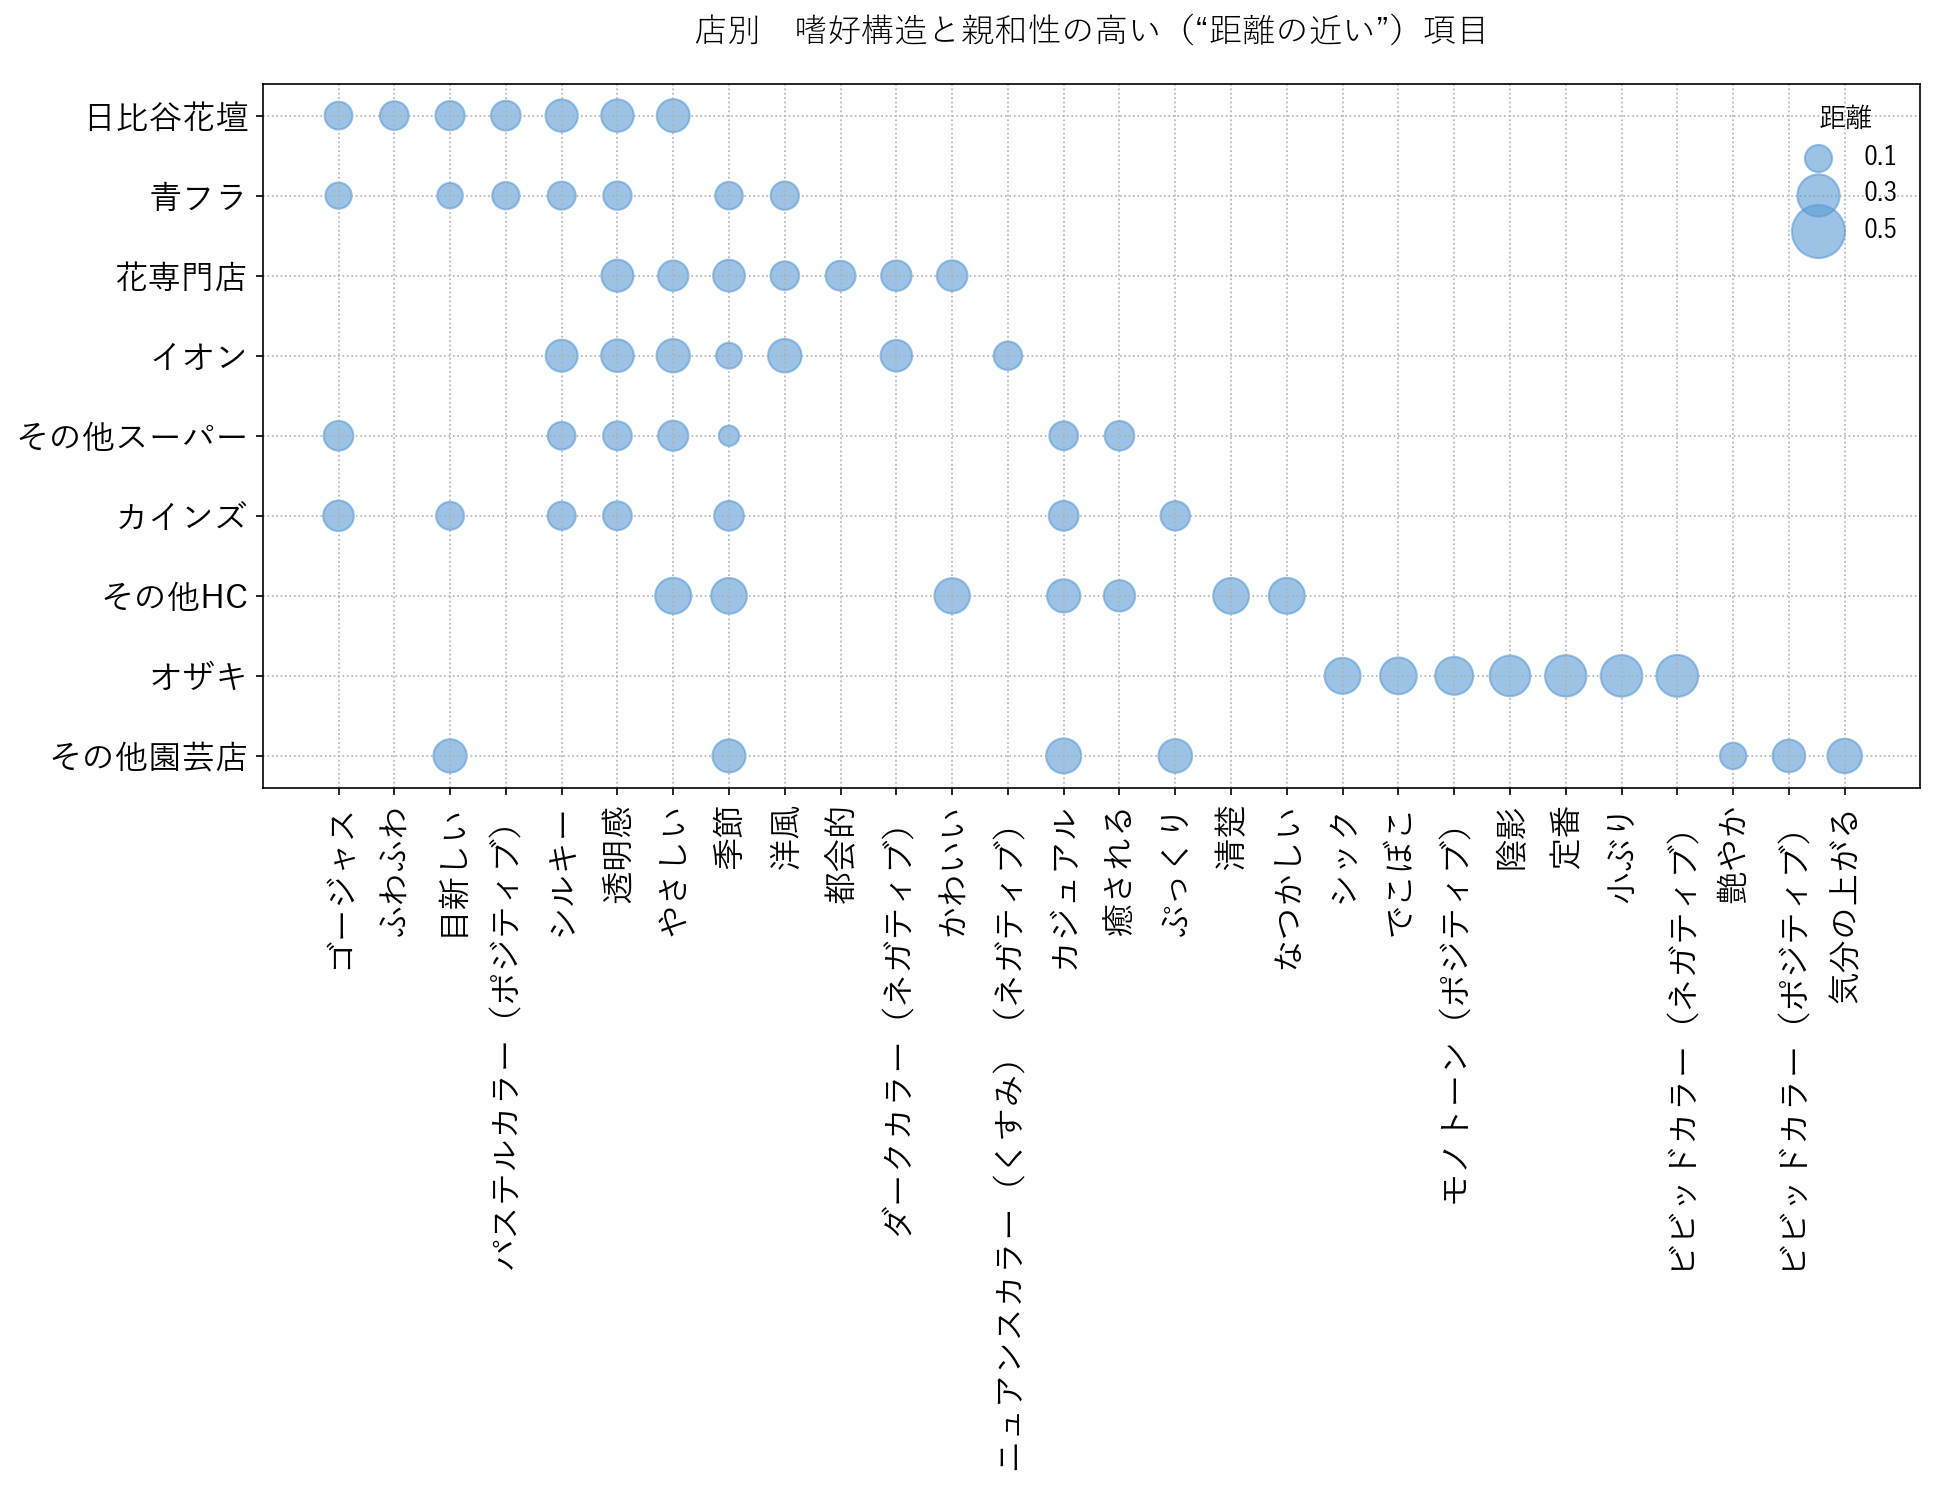

In [69]:

# -----------------------------------------------------------------------------
# 【Step 2】matplotlib による描画　店舗 × スコア項目の距離　バブルチャート
# -----------------------------------------------------------------------------

# matplotlibで描画
# snsで凡例の色など調整が難しい場合

# 店舗 × スコア項目の距離 バブルチャート 

"""
    店舗 × スコア項目の距離を、バブルの大きさで表すプロット

    Parameters:
    - distance_df: 店舗 × 項目 の距離マトリクス（DataFrame）
    - top_n: 各店舗の「距離が近い項目」をいくつ表示するか（既定=7）

    プロット仕様：
    - 横軸：項目（色調・スタイルなど）
    - 縦軸：店舗
    - バブルサイズ：距離（近いほど小さい）
"""
    
def plot_bubble_distance_chart_matplotlib(distance_df, top_n=7):
    import matplotlib.pyplot as plt

    # データ整形
    records = []
    for store in distance_df.index:
        sorted_items = distance_df.loc[store].sort_values().head(top_n)
        for item, dist in sorted_items.items():
            records.append({
                "店舗": store,
                "項目": item,
                "距離": dist
            })

    df_plot = pd.DataFrame(records)

    # 軸マップ用
    stores = df_plot["店舗"].unique()
    items = df_plot["項目"].unique()
    store_map = {s: i for i, s in enumerate(reversed(stores))}
    item_map = {i: j for j, i in enumerate(items)}

    x = [item_map[i] for i in df_plot["項目"]]
    y = [store_map[s] for s in df_plot["店舗"]]
    sizes = [d * 1200 + 50 for d in df_plot["距離"]]  # 距離が大きいほど大きなバブル

    fig, ax = plt.subplots(figsize=(13, 10), dpi=150)
    sc = ax.scatter(x, y, s=sizes, c="#5B9BD5", alpha=0.6)

    # 軸ラベル
    ax.set_xticks(list(item_map.values()))
    ax.set_xticklabels(list(item_map.keys()), rotation=90, fontsize=16)
    ax.set_yticks(list(store_map.values()))
    ax.set_yticklabels(list(store_map.keys()), fontsize=16)

    # タイトル・グリッド
    plt.title("店別　嗜好構造と親和性の高い（“距離の近い”）項目", fontsize=16, pad=20)
    plt.grid(True, linestyle=':')

    # ✅ 凡例（距離の値とバブルサイズを一致）
    for size in [0.1, 0.3, 0.5]:
        plt.scatter([], [], s=size * 1200 + 50, c="#5B9BD5", alpha=0.6, label=f"{size:.1f}")
 
    plt.legend(title="距離", loc="upper right", frameon=False, fontsize=12, title_fontsize=13)

    plt.tight_layout()
    plt.show()


# 描画
plot_bubble_distance_chart_matplotlib(df_store_item_distance, top_n=7)


In [70]:
# (5) 距離　共通項目の可視化　
# 共通して距離が大きい項目／店舗間で差が大きい項目を抽出

# -----------------------------------------------------------------------------
# 【Step 1】距離の大きい項目、店舗間の差が大きい項目を抽出
# -----------------------------------------------------------------------------

# 関数定義　analyze_common_and_variable_items()

import pandas as pd

def analyze_common_and_variable_items(distance_df, top_n=10):
    """
    - 距離が全体的に大きい項目（＝すべての店舗で“遠い”＝特徴的 or 苦手）
    - 店舗間で差が大きい項目（＝店舗によって“ブレる”＝選別軸になりやすい）

    Parameters:
    - distance_df: create_store_item_distance_matrix() の出力（店舗 × スコア項目 の距離マトリクス）
    - top_n: ランキング件数（既定＝10）

    Returns:
    - df_mean_top: 平均距離の高い項目（共通的に遠い）
    - df_std_top: 標準偏差の高い項目（店舗間で差が大きい）
    """

    # 店舗平均距離が大きい項目（＝どの店舗にとっても特徴的）
    means = distance_df.mean(axis=0).sort_values(ascending=False).head(top_n).to_frame(name="平均距離")

    # 店舗間の距離ばらつきが大きい項目（＝店舗によって“好き嫌い”が異なる）
    stds = distance_df.std(axis=0).sort_values(ascending=False).head(top_n).to_frame(name="距離のばらつき")

    return means, stds


# -----------------------------------------------------------------------------
# 【Step 2】距離大、店舗間差項目 出力
# -----------------------------------------------------------------------------

# 関数呼び出し　TOP10出力
df_common_far, df_variable_items = analyze_common_and_variable_items(df_store_item_distance, top_n=10)

# df_mean_top	どの店舗でも距離が大きい＝“共通して特徴的な項目”（例：難しい・好まれにくい）
print('共通して距離が大きい項目')
display(df_common_far)

# df_std_top	店舗によって距離がバラつく＝“差が出る項目”（＝特徴・選別に効く項目）
print('店舗によって差が出る項目')
display(df_variable_items)



共通して距離が大きい項目


,平均距離
パステルカラー（ネガティブ）,0.495678
和風,0.440811
ダークカラー（ポジティブ）,0.425700
でこぼこ,0.388567
陰影,0.381600
クール,0.377944
どっしり,0.340411
モノトーン（ポジティブ）,0.334500
野趣,0.328467
ビビッドカラー（ネガティブ）,0.327167


店舗によって差が出る項目


,距離のばらつき
気分の上がる,0.134922
大ぶり,0.132315
モノトーン（ネガティブ）,0.129758
目新しい,0.127156
ゴージャス,0.125144
季節,0.124400
ビビッドカラー（ポジティブ）,0.122733
パステルカラー（ポジティブ）,0.121291
艶やか,0.121009
ふわふわ,0.120466


In [75]:
# 7. 補足 「中立」（どちらでもない、中庸回答）の分析

"""
「どちらでもない」は、CAに含めず、「中立」として別の列にフラッグを立てている
　現実には、この中立回答の割合が大きいため、解釈時には、その大きさを加味する必要がある
　別途クラスター分析結果から、好みの曖昧な「中庸派」は、全体の 3～4割（店、性年齢により割合は異なる）
　ただし、中庸派＝中立回答 というわけではない（項目による）
　中立回答の詳細分析は、別途コードで処理
 
"""


#(1) 中立率ランキング

# -----------------------------------------------------------------------------
# 【Step 1】 中立列抽出
# -----------------------------------------------------------------------------

# 中立列の抽出（Q15, Q17の_center列）
center_columns = [col for col in ca_all_input.columns if col.endswith("_center")]


# -----------------------------------------------------------------------------
# 【Step 2】 中立列　性年齢別
# -----------------------------------------------------------------------------

# 性年齢別に中立率（平均）を集計
neutral_rate_by_age = ca_all_input.groupby("QSAGE")[center_columns].mean().round(3)
neutral_rate_by_age.index = neutral_rate_by_age.index.map(qsage_labels)

# 日本語ラベル化
neutral_rate_by_age.columns = [all_label_dict.get(col, col) for col in neutral_rate_by_age.columns]

# 中立率が高い項目順に表示
print("▶ 性年齢別 × 中立率（「どちらでもない」）:")
display(neutral_rate_by_age)



#(2) 項目別　中立率一覧

# 中立率ランキング（全体平均）
neutral_rate_total = ca_all_input[center_columns].mean().sort_values(ascending=False).round(2)
neutral_rate_total.index = [all_label_dict.get(col, col) for col in neutral_rate_total.index]

print("▶ 項目別 中立率ランキング（全体平均）:")
display(neutral_rate_total)



▶ 性年齢別 × 中立率（中庸派）:


,ビビッドカラー（中立）,パステルカラー（中立）,ニュアンスカラー（くすみ）（中立）,ダークカラー（中立）,モノトーン（中立）,かわいい（中立）,季節（中立）,カジュアル（中立）,大ぶり（中立）,ゴージャス（中立）,野趣（中立）,洋風（中立）,やさしい（中立）,シルキー（中立）,ふわふわ（中立）,ひらひら（中立）,透明感（中立）,癒される（中立）,目新しい（中立）,艶やか（中立）
QSAGE,,,,,,,,,,,,,,,,,,,,
男性20代,0.128,0.191,0.170,0.191,0.234,0.234,0.149,0.128,0.255,0.128,0.277,0.128,0.170,0.255,0.191,0.213,0.277,0.149,0.213,0.191
男性30代,0.200,0.150,0.183,0.250,0.233,0.083,0.217,0.217,0.267,0.267,0.267,0.283,0.083,0.267,0.150,0.217,0.150,0.183,0.283,0.167
男性40代,0.315,0.233,0.233,0.247,0.260,0.397,0.356,0.301,0.370,0.397,0.315,0.397,0.260,0.370,0.315,0.370,0.301,0.247,0.411,0.315
男性50代,0.353,0.353,0.294,0.247,0.271,0.329,0.282,0.435,0.424,0.424,0.424,0.329,0.259,0.435,0.353,0.400,0.353,0.353,0.529,0.318
女性20代,0.200,0.067,0.222,0.089,0.156,0.111,0.111,0.200,0.289,0.200,0.267,0.200,0.089,0.222,0.133,0.222,0.178,0.133,0.311,0.178
女性30代,0.300,0.180,0.140,0.140,0.200,0.160,0.200,0.280,0.280,0.300,0.340,0.300,0.140,0.380,0.120,0.320,0.180,0.200,0.320,0.240
女性40代,0.164,0.164,0.151,0.178,0.205,0.205,0.151,0.315,0.301,0.315,0.411,0.370,0.205,0.370,0.315,0.315,0.260,0.274,0.438,0.233
女性50代,0.212,0.224,0.118,0.141,0.153,0.188,0.271,0.329,0.400,0.341,0.412,0.282,0.212,0.447,0.282,0.447,0.341,0.271,0.471,0.294


▶ 項目別 中立率ランキング（全体平均）:


目新しい（中立）             0.39
シルキー（中立）             0.36
野趣（中立）               0.35
大ぶり（中立）              0.34
ひらひら（中立）             0.33
ゴージャス（中立）            0.31
洋風（中立）               0.30
カジュアル（中立）            0.29
透明感（中立）              0.27
艶やか（中立）              0.25
ふわふわ（中立）             0.25
癒される（中立）             0.24
ビビッドカラー（中立）          0.24
季節（中立）               0.23
かわいい（中立）             0.23
モノトーン（中立）            0.22
パステルカラー（中立）          0.21
ダークカラー（中立）           0.19
ニュアンスカラー（くすみ）（中立）    0.19
やさしい（中立）             0.19
dtype: float64